In [1]:
import os
os.chdir("..")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from pathlib import Path

from SSTImportanceSampling  import Preprocessor, AdaptParams, AdaptiveMixtureSampler

from SSTImportanceSampling.utils import summarize_depths_by_return_period
from SSTImportanceSampling.utils import metrics
from SSTImportanceSampling.utils import plot_two_return_period_summaries
from SSTImportanceSampling.utils import plot_adaptive_evolution


In [3]:
watershed_names = ["Trinity","Kanawha","Duwamish","Denton"]

In [4]:
#Load data
watersheds = {}

for wname in watershed_names:
    ws = Preprocessor.load(
        config_path=f"/workspaces/Importance-Sampling-for-SST/data/1_interim/{wname}/config.json"
    )
    watersheds[wname] = ws

In [6]:
#Full Monte Carlo summary
base_dir = "/workspaces/Importance-Sampling-for-SST/data/2_production"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

In [161]:
watershed = watersheds["Trinity"]
watershed_name = "Trinity"

In [162]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.domain_stats["x"],
    mu_y_w=watershed.domain_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"]/np.sqrt(12),
    sd_y_w=watershed.domain_stats["range_y"]/np.sqrt(12),

    rho_n=0,      # correlation narrow
    rho_w=0,       # correlation wide
    mix=0.8,         # initial mixture weight for narrow
    alpha = 0.75,
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed = 42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=50.8)

In [163]:
history

iter     n  updated       mix        mu_x_n        mu_y_n         sd_x_n  \
0      0     0        0  0.800000 -47423.503597  1.019272e+06  393466.000014   
1      1  1000        1  0.827339 -51741.474639  9.687653e+05  241749.286435   
2      2  1000        1  0.854799 -45491.210419  9.502735e+05  187805.077163   
3      3  1000        1  0.879599 -55007.926028  9.626190e+05  158679.979602   
4      4  1000        1  0.895198 -58041.145450  9.556363e+05  146724.779686   
5      5  1000        1  0.910329 -47694.161290  9.346387e+05  144078.649949   
6      6  1000        1  0.922196 -50987.395489  9.399338e+05  147860.495702   
7      7  1000        1  0.928493 -66040.393269  9.442800e+05  142655.990928   
8      8  1000        1  0.932175 -58556.457188  9.412444e+05  144138.210060   
9      9  1000        1  0.944704 -60025.187987  9.502373e+05  137138.679908   
10    10  1000        1  0.945408 -44427.635243  9.509013e+05  140070.886842   

           sd_y_n     rho_n  beta_hat_reward  
0   444468.700707  0.000000              NaN  
1   270840.550669  0.090028         0.891130  
2   202261.565879  0.074411         0.918873  
3   183046.243970  0.008891         0.937464  
4   178947.199999  0.012271         0.931598  
5   177377.440540  0.069443         0.945635  
6   174961.694120  0.090246         0.949884  
7   177126.633117  0.077012         0.943186  
8   179178.542253  0.021304         0.940766  
9   175076.991522  0.000490         0.973940  
10  182341.152084  0.069473         0.947050

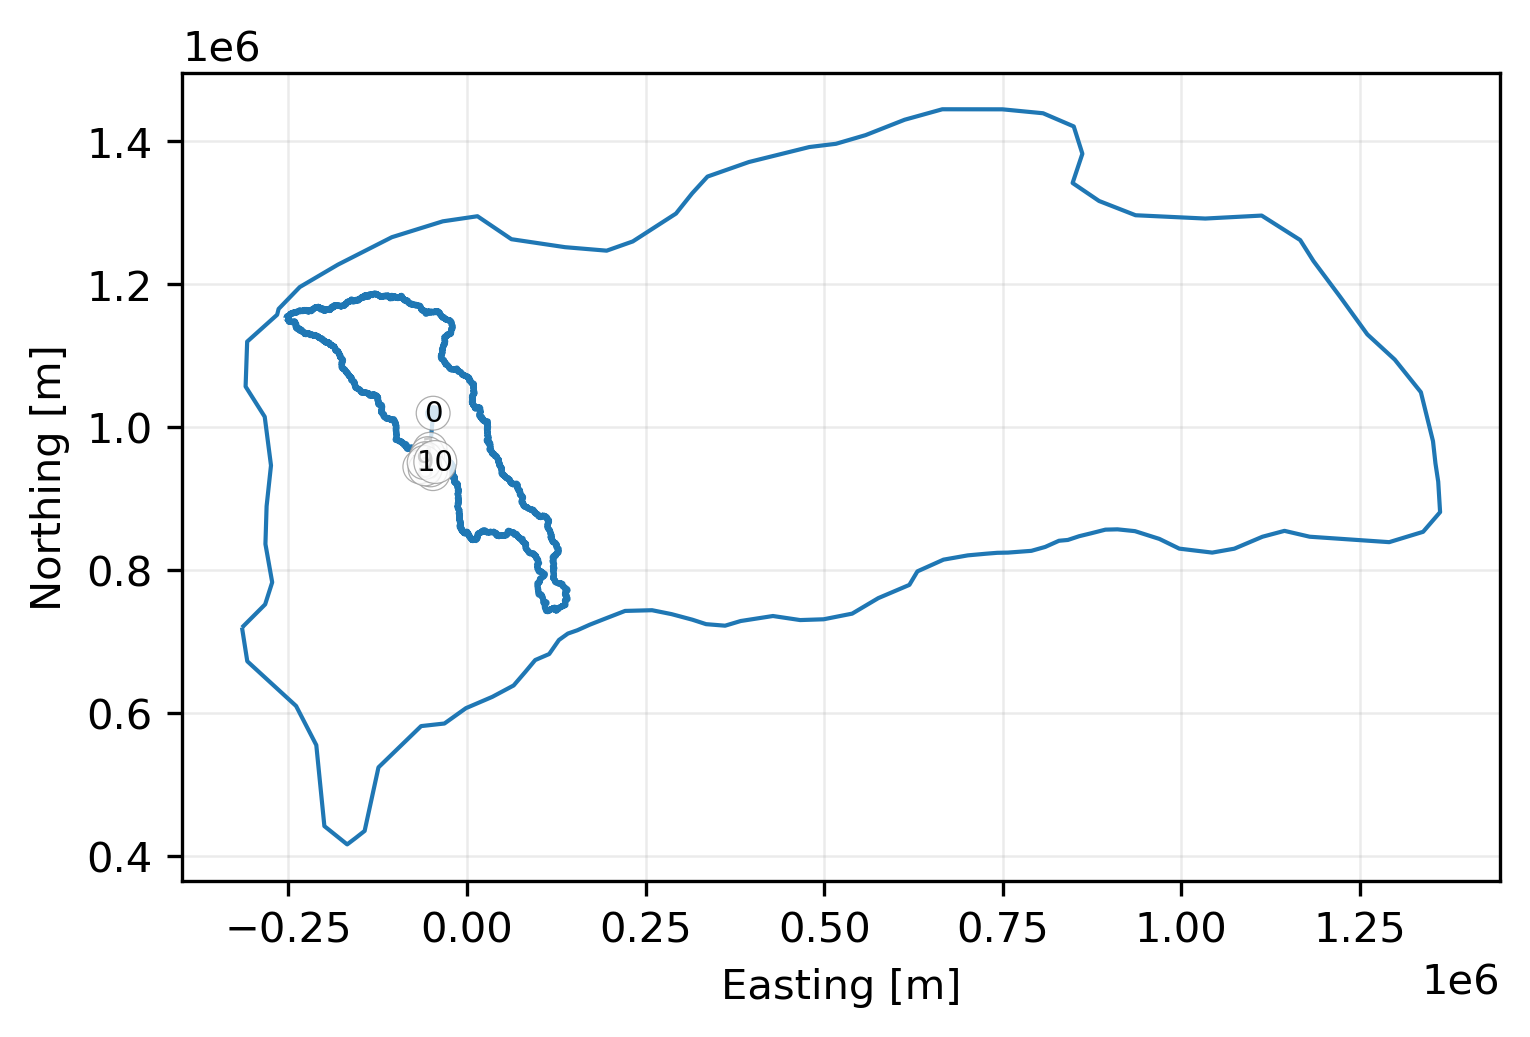

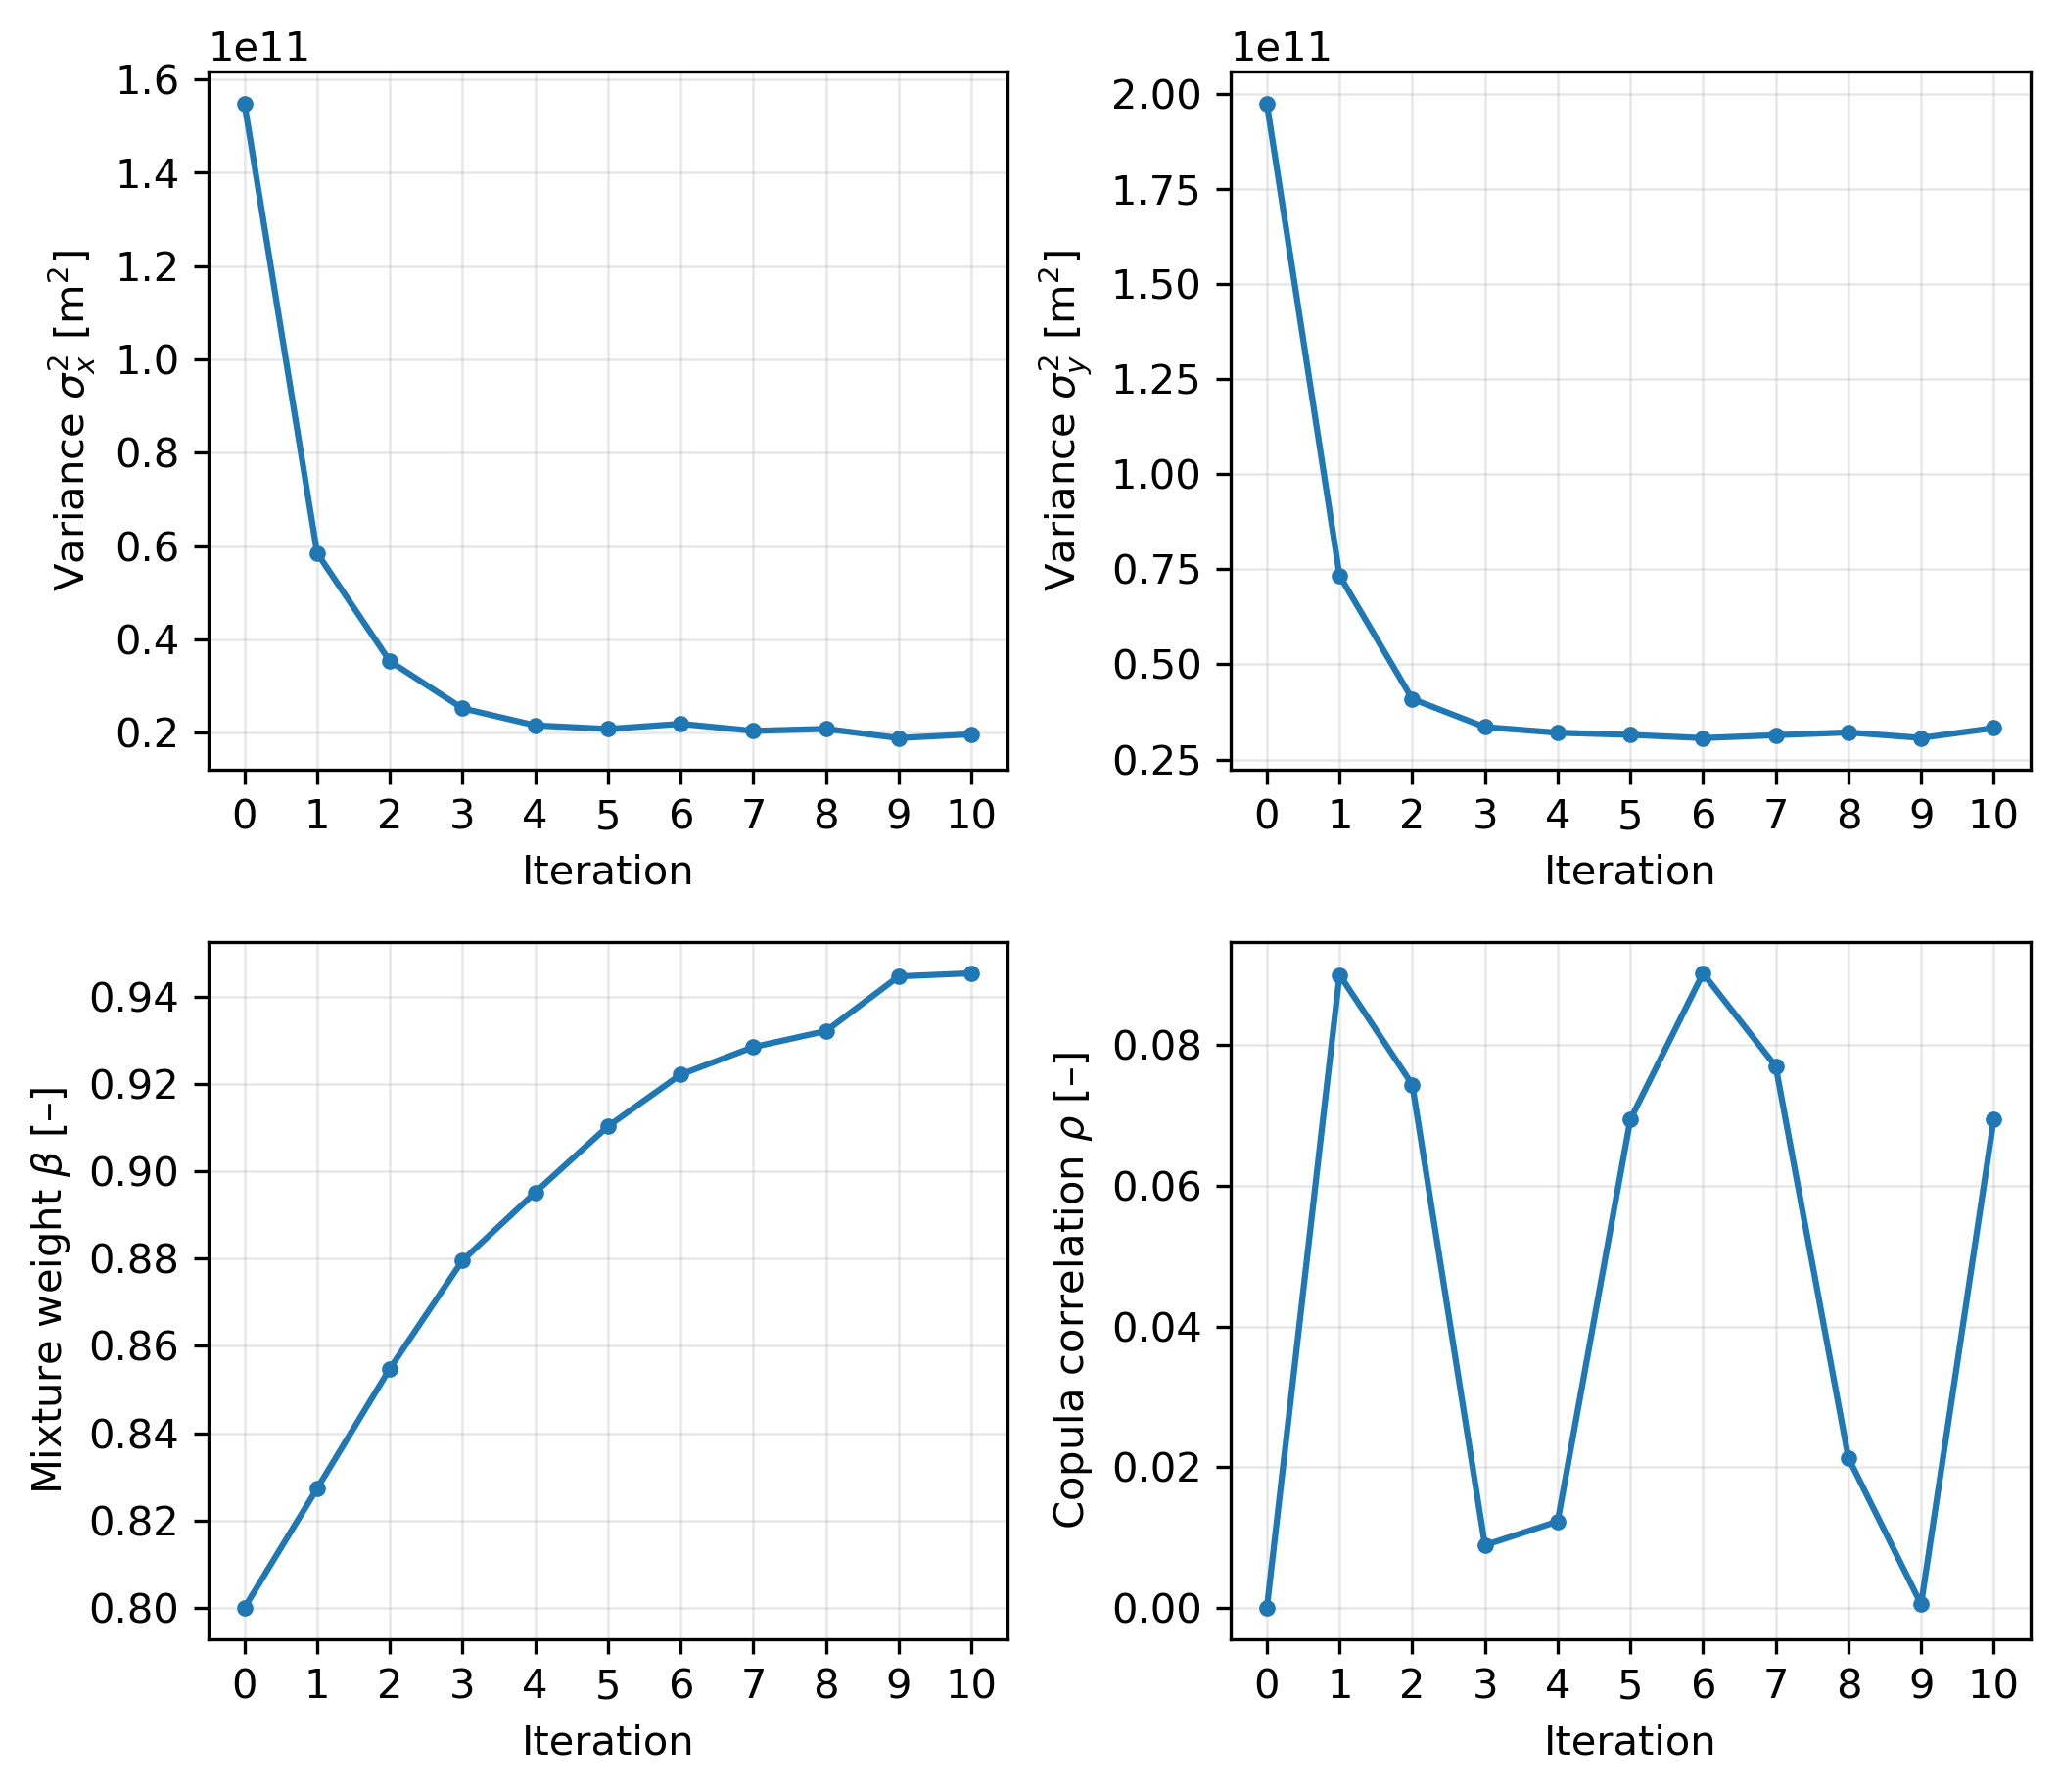

In [164]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="trinity_ais")

In [25]:
final_df = sampler.sample_final(n=13_000, num_realizations=50, with_depths=True)

In [26]:
final_df

realization  realization_seed  event_id              storm_path  \
0                 1      9.406074e+17         1  20210325_72hr_st1_r420   
1                 1      9.406074e+17         2  19800327_72hr_st1_r125   
2                 1      9.406074e+17         3  19910109_72hr_st1_r225   
3                 1      9.406074e+17         4  20000503_72hr_st3_r297   
4                 1      9.406074e+17         5  20161203_72hr_st1_r146   
...             ...               ...       ...                     ...   
649995           50      1.530213e+19     12996  19790411_72hr_st1_r045   
649996           50      1.530213e+19     12997  20040210_72hr_st1_r285   
649997           50      1.530213e+19     12998  19791120_72hr_st1_r355   
649998           50      1.530213e+19     12999  19991008_72hr_st5_r182   
649999           50      1.530213e+19     13000  19950314_72hr_st1_r376   

               x          y           newx          newy           delx  \
0       938000.0  1262000.0   74953.464725  1.009549e+06 -863046.535275   
1       586000.0   934000.0  418953.464725  9.215487e+05 -167046.535275   
2       322000.0   730000.0 -105046.535275  6.815487e+05 -427046.535275   
3       310000.0   778000.0  -41046.535275  7.815487e+05 -351046.535275   
4       242000.0   766000.0  114953.464725  7.295487e+05 -127046.535275   
...          ...        ...            ...           ...            ...   
649995  646000.0  1146000.0 -137046.535275  1.009549e+06 -783046.535275   
649996  294000.0   846000.0 -125046.535275  8.455487e+05 -419046.535275   
649997  474000.0  1310000.0 -105046.535275  1.165549e+06 -579046.535275   
649998  722000.0   838000.0   50953.464725  6.815487e+05 -671046.535275   
649999  546000.0   986000.0  130953.464725  9.855487e+05 -415046.535275   

                 dely  weight_raw    weight  precip_avg_mm   exc_prb  
0      -252451.321602    0.215993  0.000017      65.003906  0.348426  
1       -12451.321602   19.780596  0.001526      46.447403  0.604533  
2       -48451.321602    0.760458  0.000059      53.105911  0.523608  
3         3548.678398    0.436079  0.000034      73.682747  0.234798  
4       -36451.321602    1.307238  0.000101      64.338730  0.358688  
...               ...         ...       ...            ...       ...  
649995 -136451.321602    0.532091  0.000040     119.909126  0.022105  
649996    -451.321602    0.524234  0.000039      73.911552  0.222034  
649997 -144451.321602    0.417999  0.000031      52.213314  0.522436  
649998 -156451.321602    0.608664  0.000046      73.649406  0.225085  
649999    -451.321602    0.812289  0.000061      48.920643  0.565675  

[650000 rows x 14 columns]

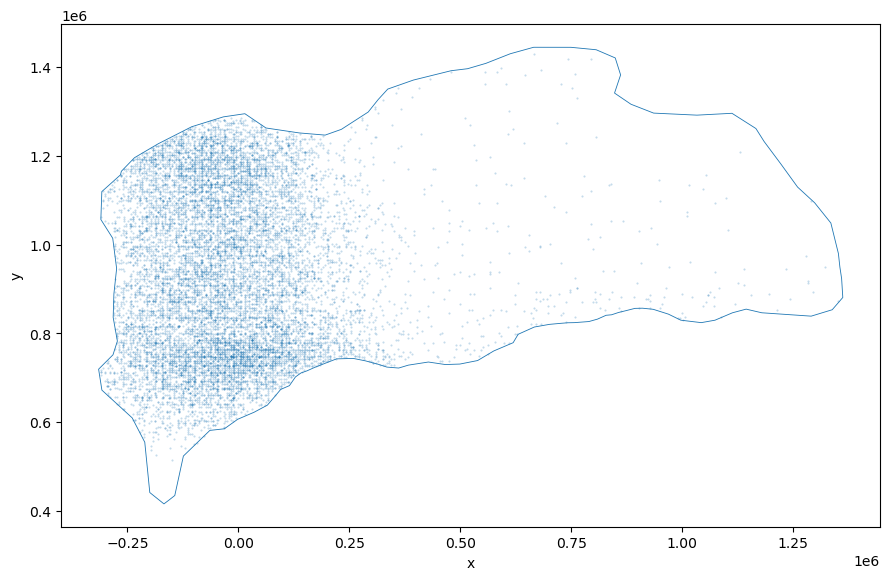

In [38]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx[final_df["realization"] == 1], final_df.newy[final_df["realization"]==1], s=0.2, alpha=0.3, rasterized=False)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [39]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [40]:
m = metrics(summaries["Trinity"],adaptive_summary)
m

n_points  rp_min_used  rp_max_used  rmse_mean  rmse_median  rmse_ci95_low  \
0      1999          2.0       2000.0   0.055137     0.044779       0.148501   

   rmse_ci95_high  rmse_ci90_low  rmse_ci90_high  me_mean  ...  me_ci95_low  \
0        0.043752       0.113895        0.042709 -0.05236  ...     -0.14208   

   me_ci95_high  me_ci90_low  me_ci90_high  diff_at_maxrp_mean  \
0     -0.036107    -0.105944     -0.037633           -0.051142   

   diff_at_maxrp_median  diff_at_maxrp_ci95_low  diff_at_maxrp_ci95_high  \
0             -0.049521               -0.096641                 -0.02652   

   diff_at_maxrp_ci90_low  diff_at_maxrp_ci90_high  
0               -0.072997                -0.034894  

[1 rows x 21 columns]

In [41]:
adaptive_summary

RP   mean_in  median_in  ci90_low_in  ci90_high_in  ci95_low_in  \
0        2  3.834430   3.833178     3.779054      3.904980     3.766181   
1        3  4.331522   4.326956     4.263166      4.406644     4.258584   
2        4  4.605391   4.609239     4.535440      4.674485     4.521372   
3        5  4.791818   4.790272     4.711198      4.866148     4.702586   
4        6  4.930055   4.925101     4.876955      5.000536     4.863020   
...    ...       ...        ...          ...           ...          ...   
1994  1996  9.115108   9.145682     8.892334      9.255214     8.856757   
1995  1997  9.115204   9.145724     8.892519      9.255300     8.856965   
1996  1998  9.115300   9.145765     8.892703      9.255385     8.857172   
1997  1999  9.115396   9.145807     8.892888      9.255470     8.857379   
1998  2000  9.115492   9.145849     8.893072      9.255556     8.857586   

      ci95_high_in  n_realizations  n_samples_per_realization  
0         3.911201              50                      13000  
1         4.427146              50                      13000  
2         4.676793              50                      13000  
3         4.872466              50                      13000  
4         5.019925              50                      13000  
...            ...             ...                        ...  
1994      9.270158              50                      13000  
1995      9.270275              50                      13000  
1996      9.270392              50                      13000  
1997      9.270509              50                      13000  
1998      9.270626              50                      13000  

[1999 rows x 9 columns]

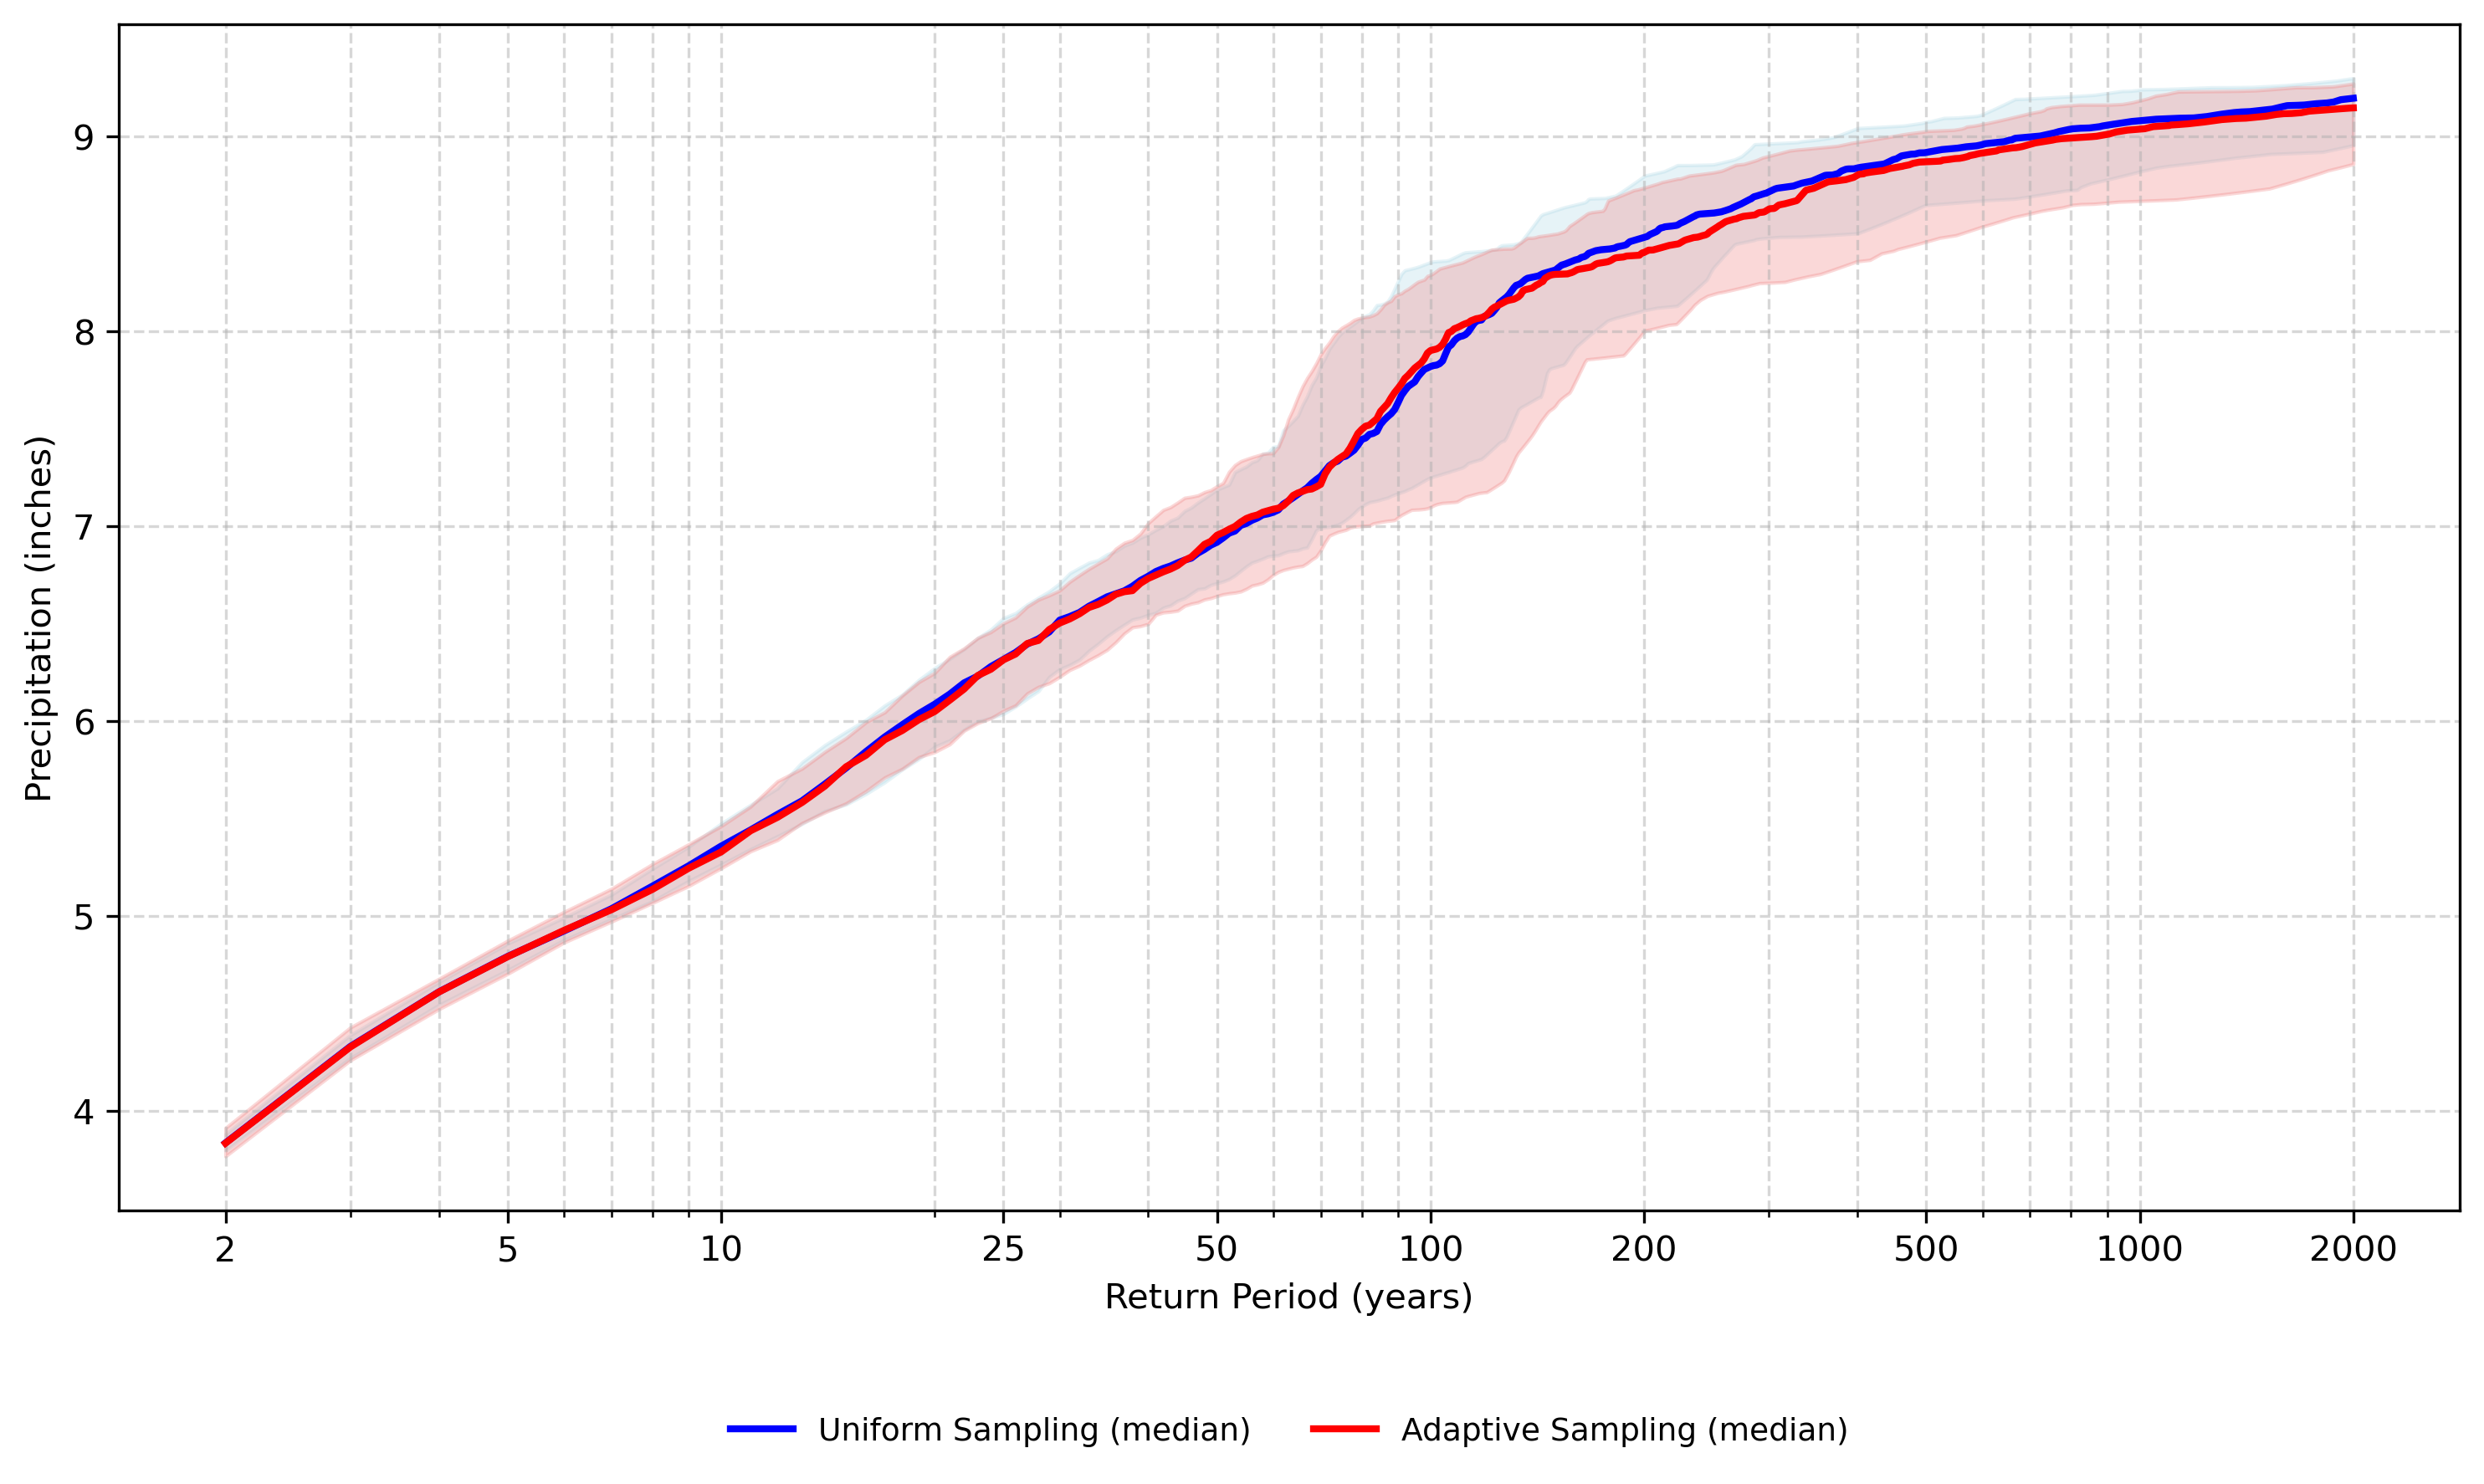

In [ ]:
plot_two_return_period_summaries(
    summary1= summaries["Trinity"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling", 
    label2="Adaptive Sampling",
    title=""
)

In [47]:
loc = Path(f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}")
final_df.to_parquet(loc / "adaptive_depths.pq", index=False)
adaptive_summary.to_parquet(loc / "adaptive_summary.pq", index=False)

In [185]:
watershed = watersheds["Kanawha"]
watershed_name = "Kanawha"

In [186]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.domain_stats["x"],
    mu_y_w=watershed.domain_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"]/np.sqrt(12),
    sd_y_w=watershed.domain_stats["range_y"]/np.sqrt(12),

    rho_n=0,      # correlation narrow
    rho_w=0,       # correlation wide
    mix=0.9,         # initial mixture weight for narrow
    alpha = 0.75
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=2000, depth_threshold=25.4)

In [187]:
history

iter     n  updated       mix        mu_x_n        mu_y_n         sd_x_n  \
0      0     0        0  0.900000  1.308114e+06  1.738215e+06  218409.555672   
1      1  2000        1  0.897574  1.266769e+06  1.661608e+06  171076.351908   
2      2  2000        1  0.905218  1.256450e+06  1.636008e+06  159225.487212   
3      3  2000        1  0.912114  1.258322e+06  1.639875e+06  157251.141090   
4      4  2000        1  0.915553  1.248033e+06  1.631737e+06  151127.972274   
5      5  2000        1  0.920941  1.255737e+06  1.631041e+06  151325.654706   
6      6  2000        1  0.924176  1.254247e+06  1.627903e+06  155101.049638   
7      7  2000        1  0.925274  1.256428e+06  1.632367e+06  155930.714619   
8      8  2000        1  0.927690  1.254115e+06  1.628134e+06  153476.008392   
9      9  2000        1  0.926831  1.251255e+06  1.625975e+06  148120.213048   
10    10  2000        1  0.928925  1.252669e+06  1.626627e+06  151052.546861   

           sd_y_n     rho_n  beta_hat_reward  
0   316501.199029  0.000000              NaN  
1   217957.680277  0.434605         0.891914  
2   189106.685109  0.567774         0.923052  
3   178634.958796  0.631651         0.928204  
4   171459.384707  0.586069         0.923579  
5   166248.121336  0.606095         0.933513  
6   169923.390250  0.616777         0.931722  
7   175294.944931  0.623125         0.927837  
8   169245.816436  0.612861         0.933328  
9   162415.040323  0.532791         0.924827  
10  161975.230972  0.540042         0.933811

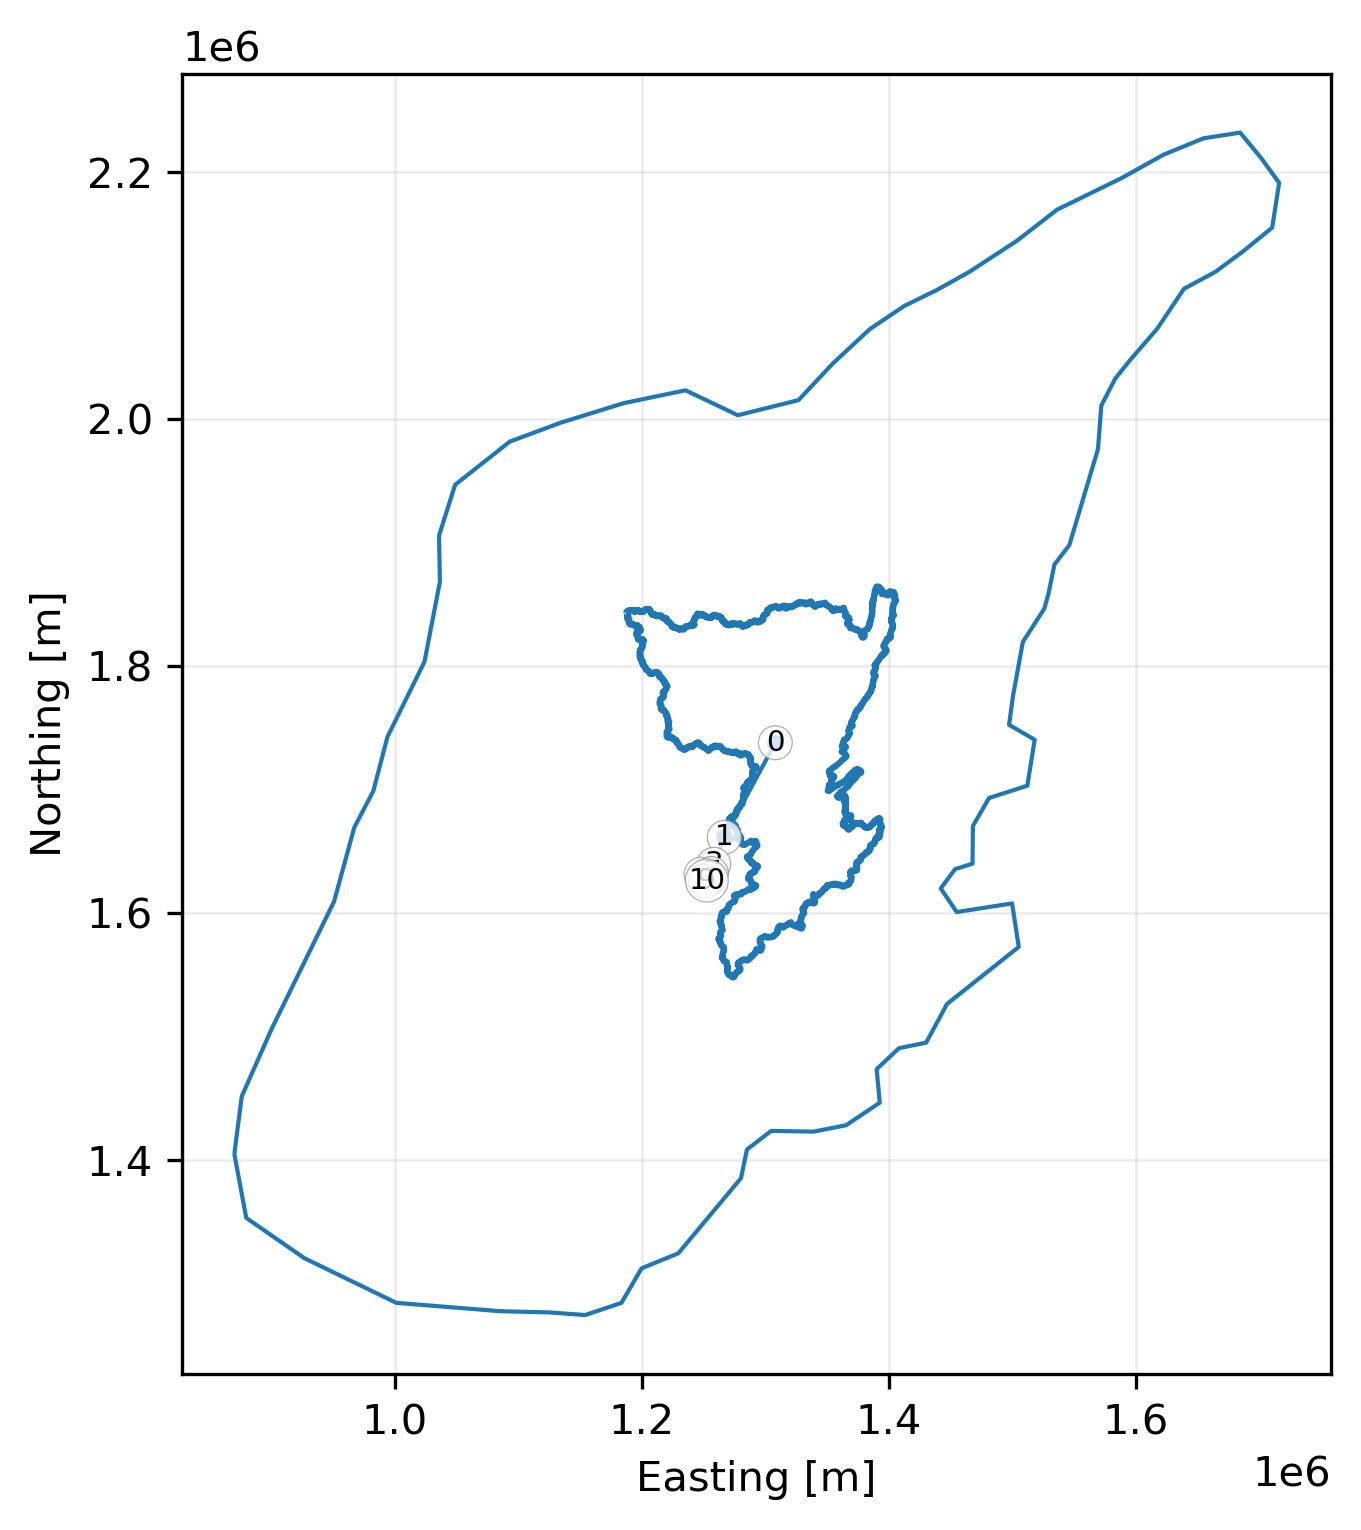

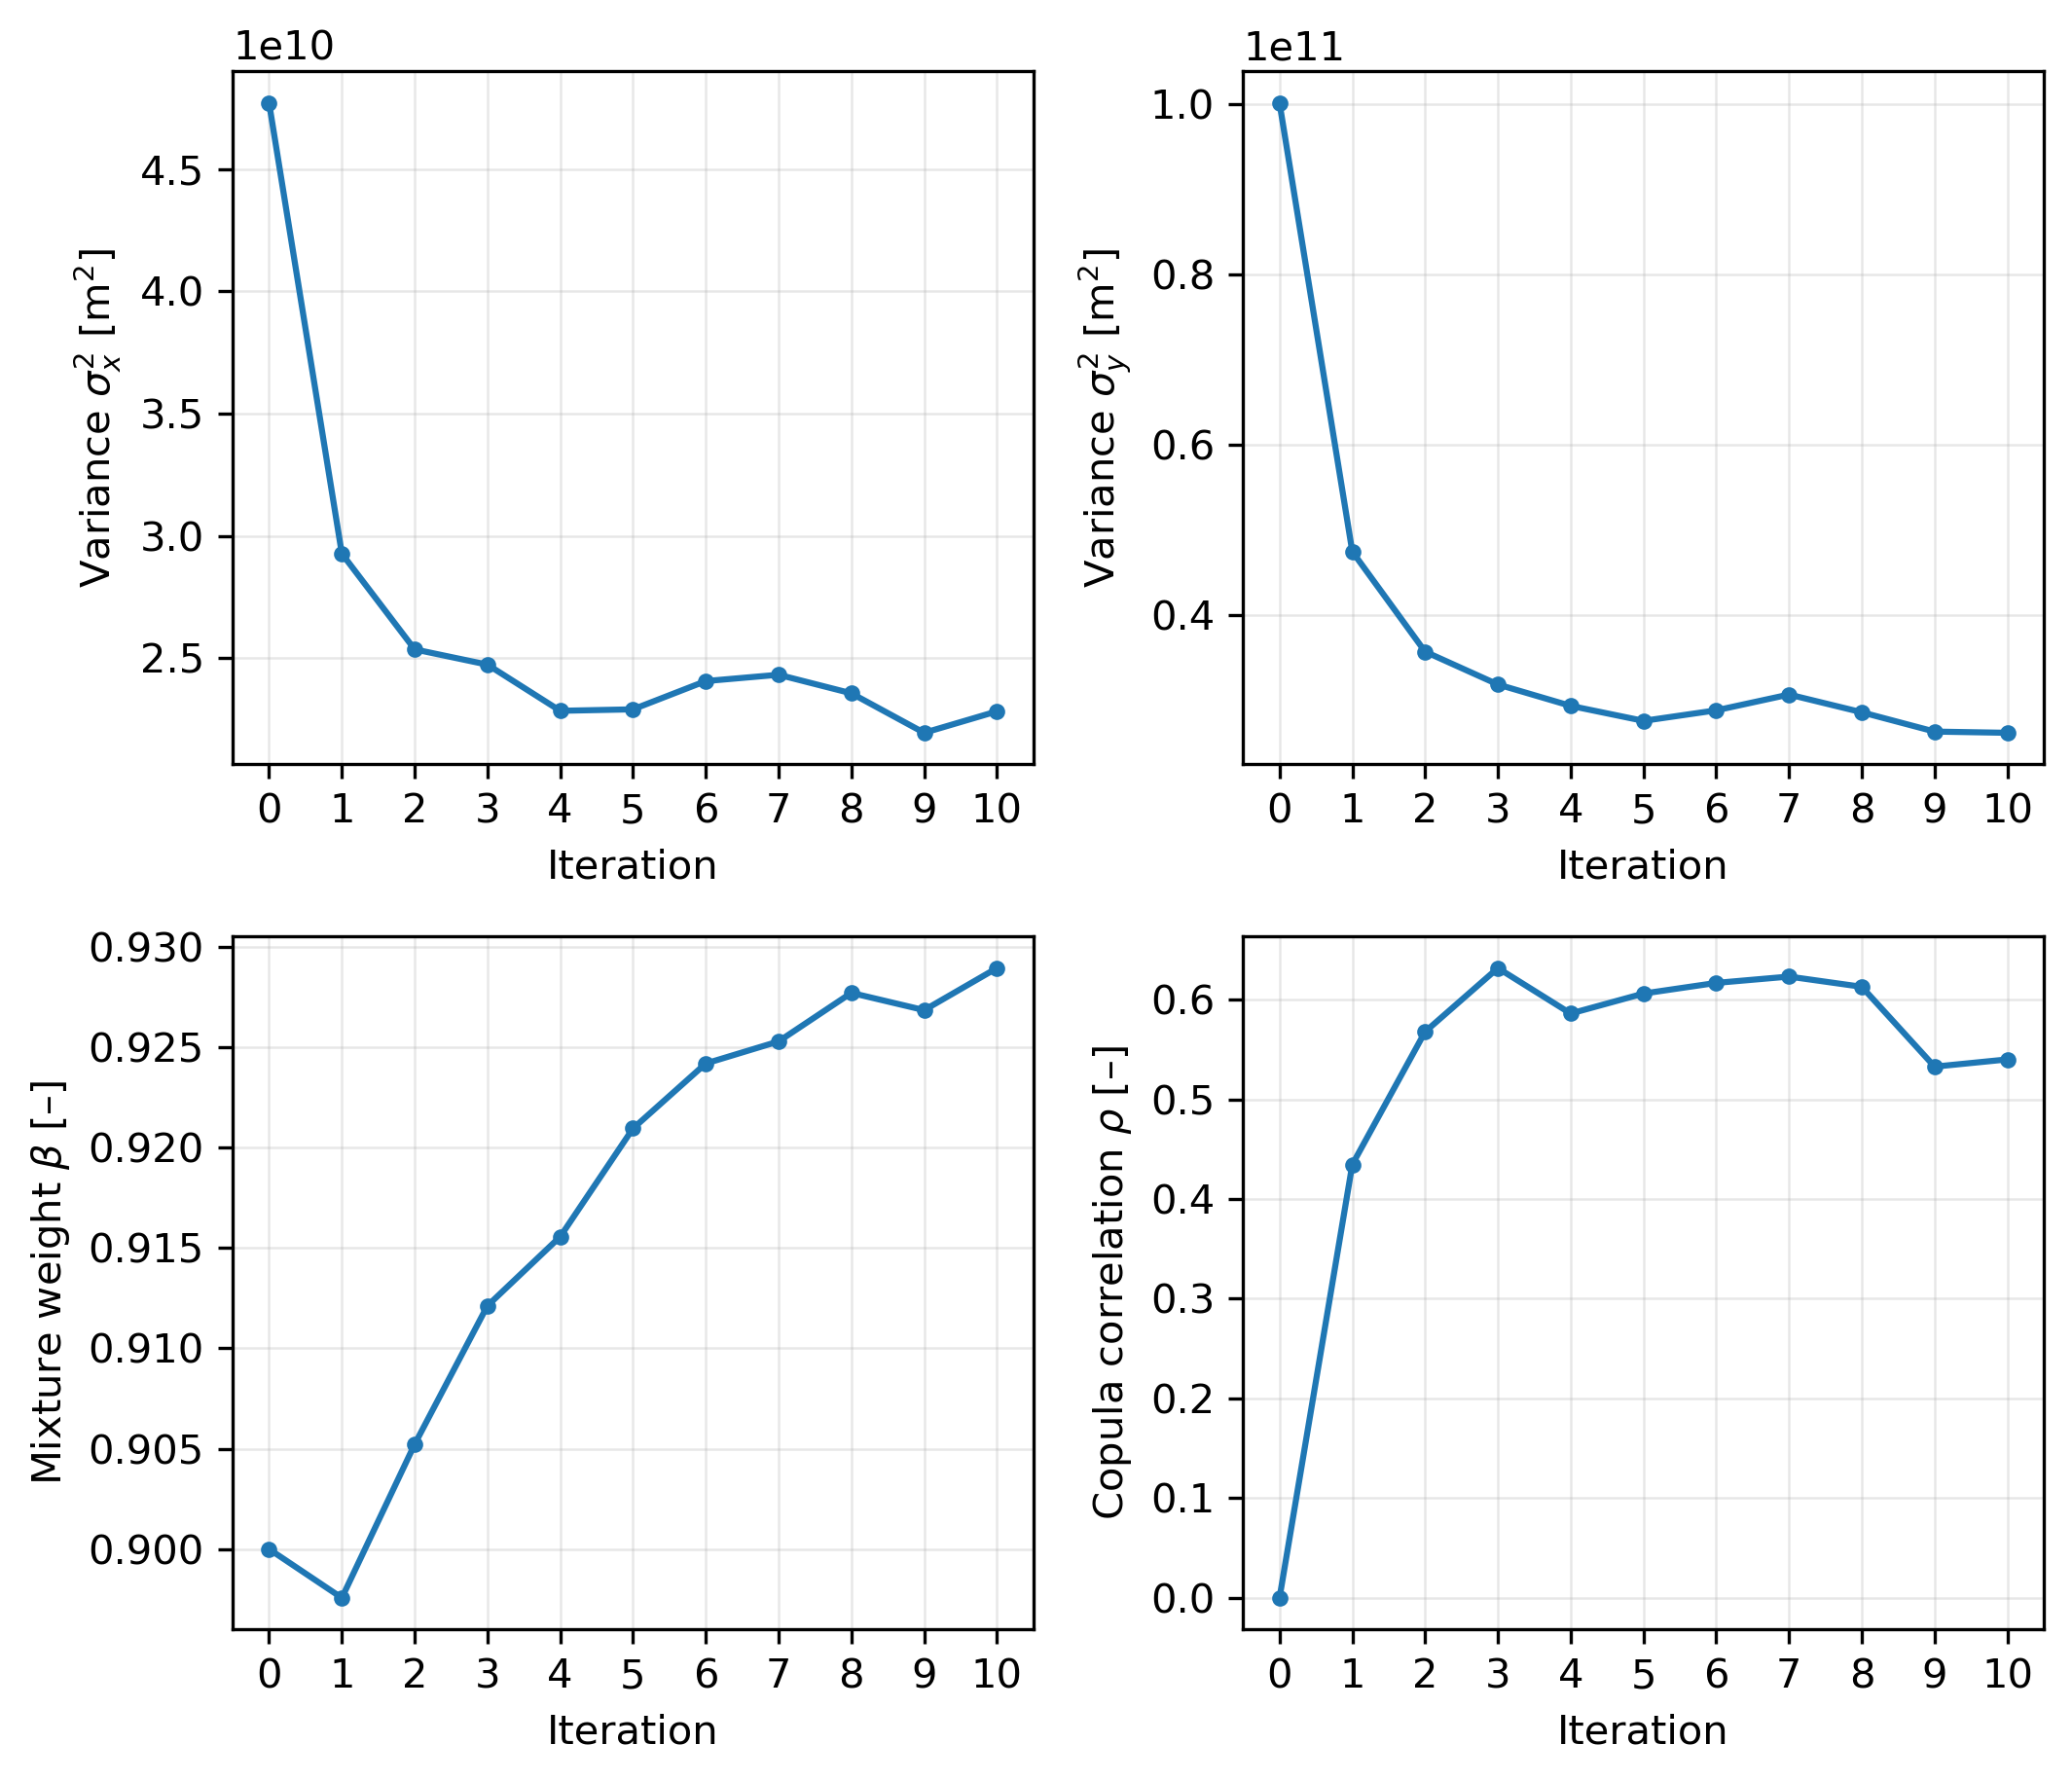

In [188]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="kanawha_ais")

In [189]:
final_df = sampler.sample_final(n=11000, num_realizations=50, with_depths=True)

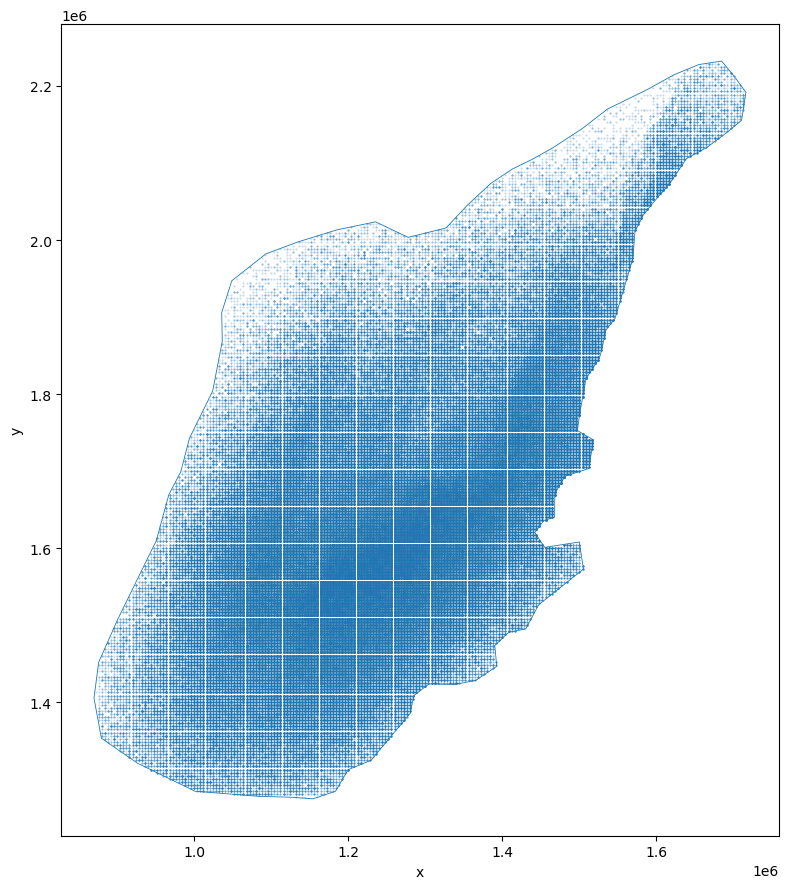

In [190]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [191]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [192]:
m = metrics(summaries["Kanawha"],adaptive_summary)
m

n_points  rp_min_used  rp_max_used  rmse_mean  rmse_median  rmse_ci95_low  \
0      1999          2.0       2000.0   0.016382      0.02227       0.031495   

   rmse_ci95_high  rmse_ci90_low  rmse_ci90_high   me_mean  ...  me_ci95_low  \
0        0.048874       0.049196        0.037711  0.012925  ...    -0.014911   

   me_ci95_high  me_ci90_low  me_ci90_high  diff_at_maxrp_mean  \
0      0.038776    -0.040164      0.031298             0.00811   

   diff_at_maxrp_median  diff_at_maxrp_ci95_low  diff_at_maxrp_ci95_high  \
0               0.01558                -0.06994                -0.010661   

   diff_at_maxrp_ci90_low  diff_at_maxrp_ci90_high  
0               -0.058651                -0.004397  

[1 rows x 21 columns]

In [193]:
adaptive_summary

RP   mean_in  median_in  ci90_low_in  ci90_high_in  ci95_low_in  \
0        2  2.709108   2.709213     2.683307      2.738809     2.667792   
1        3  3.038323   3.035718     3.004596      3.075934     2.989553   
2        4  3.241372   3.244400     3.195752      3.288231     3.190883   
3        5  3.400996   3.393915     3.354975      3.467579     3.337968   
4        6  3.523788   3.521060     3.480420      3.588042     3.472557   
...    ...       ...        ...          ...           ...          ...   
1994  1996  5.650528   5.672454     5.469433      5.733760     5.424075   
1995  1997  5.650587   5.672471     5.469501      5.733831     5.424205   
1996  1998  5.650646   5.672487     5.469570      5.733902     5.424336   
1997  1999  5.650706   5.672504     5.469638      5.733972     5.424466   
1998  2000  5.650765   5.672521     5.469707      5.734043     5.424597   

      ci95_high_in  n_realizations  n_samples_per_realization  
0         2.751855              50                      11000  
1         3.084507              50                      11000  
2         3.298386              50                      11000  
3         3.479201              50                      11000  
4         3.593083              50                      11000  
...            ...             ...                        ...  
1994      5.737673              50                      11000  
1995      5.737696              50                      11000  
1996      5.737719              50                      11000  
1997      5.737742              50                      11000  
1998      5.737765              50                      11000  

[1999 rows x 9 columns]

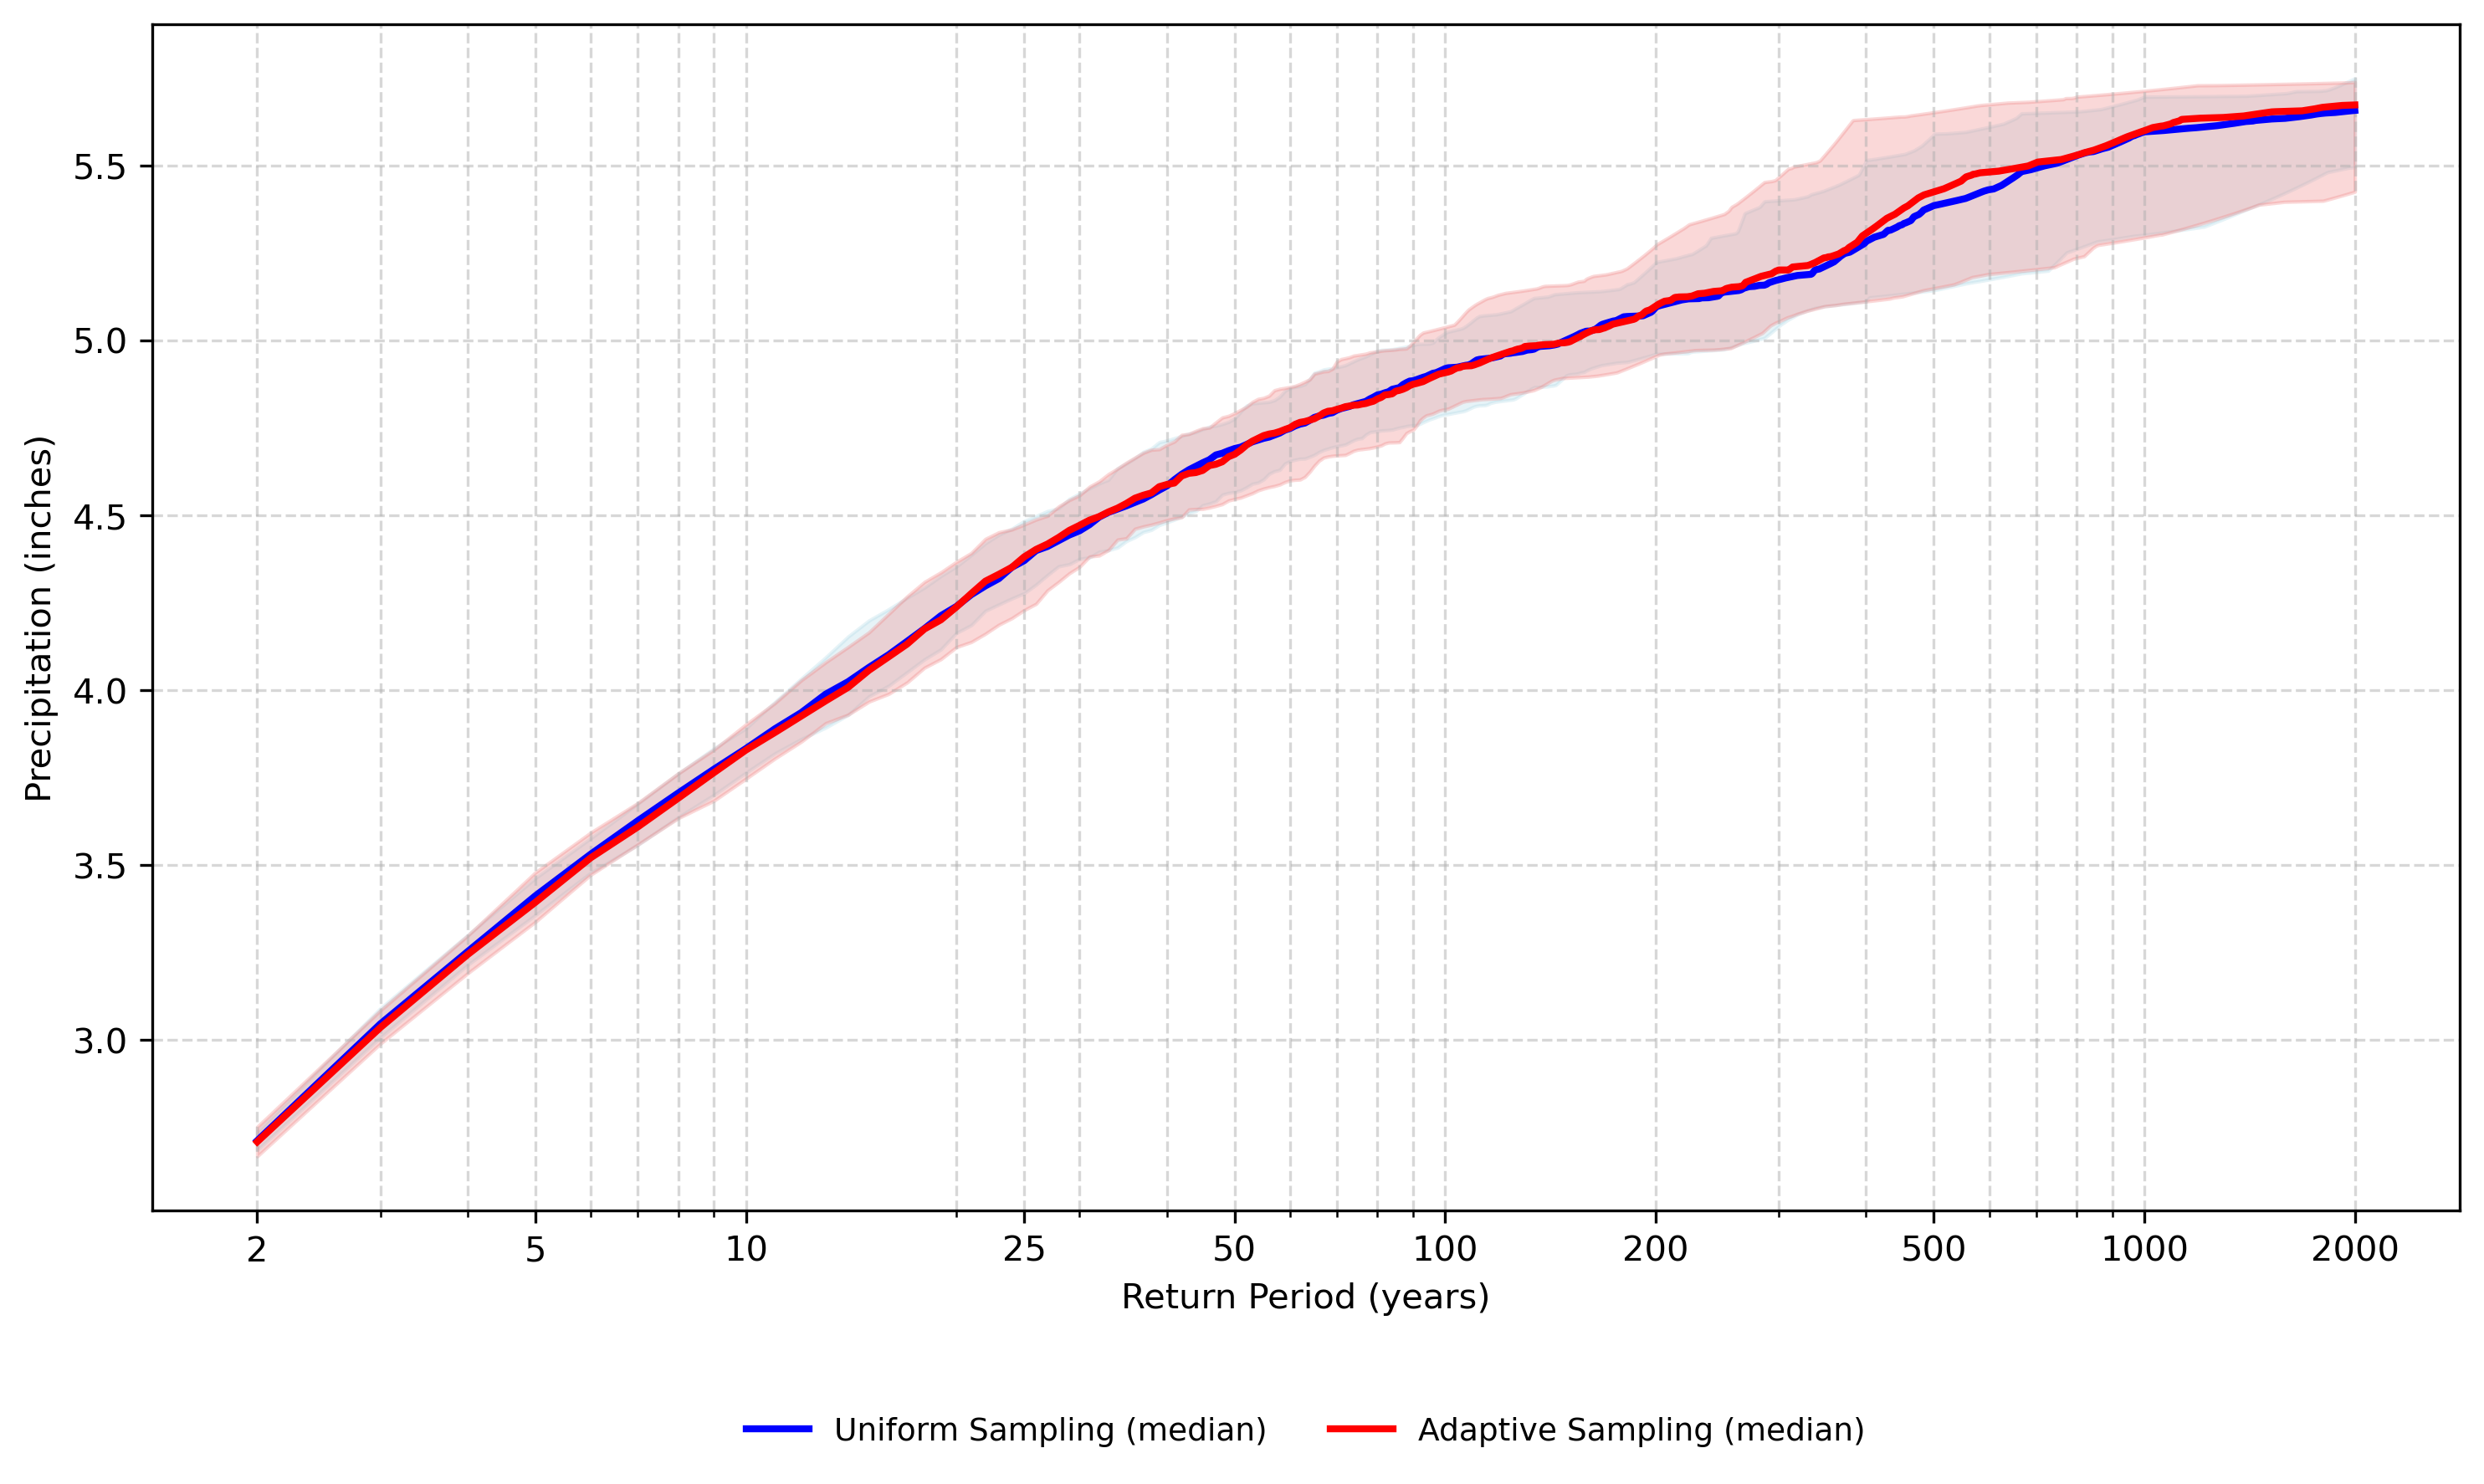

In [194]:
plot_two_return_period_summaries(
    summary1= summaries["Kanawha"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)

In [195]:
loc = Path(f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}")
final_df.to_parquet(loc / "adaptive_depths.pq", index=False)
adaptive_summary.to_parquet(loc / "adaptive_summary.pq", index=False)

In [174]:
watershed = watersheds["Duwamish"]
watershed_name = "Duwamish"

In [175]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.domain_stats["x"],
    mu_y_w=watershed.domain_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"]/np.sqrt(12),
    sd_y_w=watershed.domain_stats["range_y"]/np.sqrt(12),

    rho_n=0,      # correlation narrow
    rho_w=0,       # correlation wide
    mix=0.8,         # initial mixture weight for narrow
    alpha = 0.75,
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=50.8)

In [176]:
history

iter     n  updated       mix        mu_x_n        mu_y_n        sd_x_n  \
0      0     0        0  0.800000 -1.942311e+06  2.965860e+06  69459.812896   
1      1  1000        1  0.797496 -1.925674e+06  2.991975e+06  56430.000869   
2      2  1000        1  0.807880 -1.921937e+06  2.993537e+06  54483.860459   
3      3  1000        1  0.827839 -1.921841e+06  2.996889e+06  47970.394264   
4      4  1000        1  0.829692 -1.925138e+06  2.995756e+06  46457.344699   
5      5  1000        1  0.834241 -1.922558e+06  2.999172e+06  46451.843351   
6      6  1000        1  0.838251 -1.918812e+06  3.003532e+06  49996.307517   
7      7  1000        1  0.824325 -1.921414e+06  2.997328e+06  48998.867118   
8      8  1000        1  0.825481 -1.922482e+06  2.994446e+06  47882.459580   
9      9  1000        1  0.834163 -1.922656e+06  2.997782e+06  46892.731917   
10    10  1000        1  0.828816 -1.922567e+06  2.997417e+06  49693.663429   

          sd_y_n     rho_n  beta_hat_reward  
0   67306.945629  0.000000              NaN  
1   75345.341385  0.373635         0.791653  
2   77765.763276  0.550736         0.832108  
3   77672.898004  0.511005         0.874413  
4   78566.898854  0.493809         0.834013  
5   76831.927092  0.509058         0.844858  
6   80667.125106  0.511462         0.847608  
7   81053.135203  0.525790         0.791829  
8   78659.062844  0.532218         0.828178  
9   78474.093658  0.518343         0.854421  
10  80497.348293  0.571025         0.816340

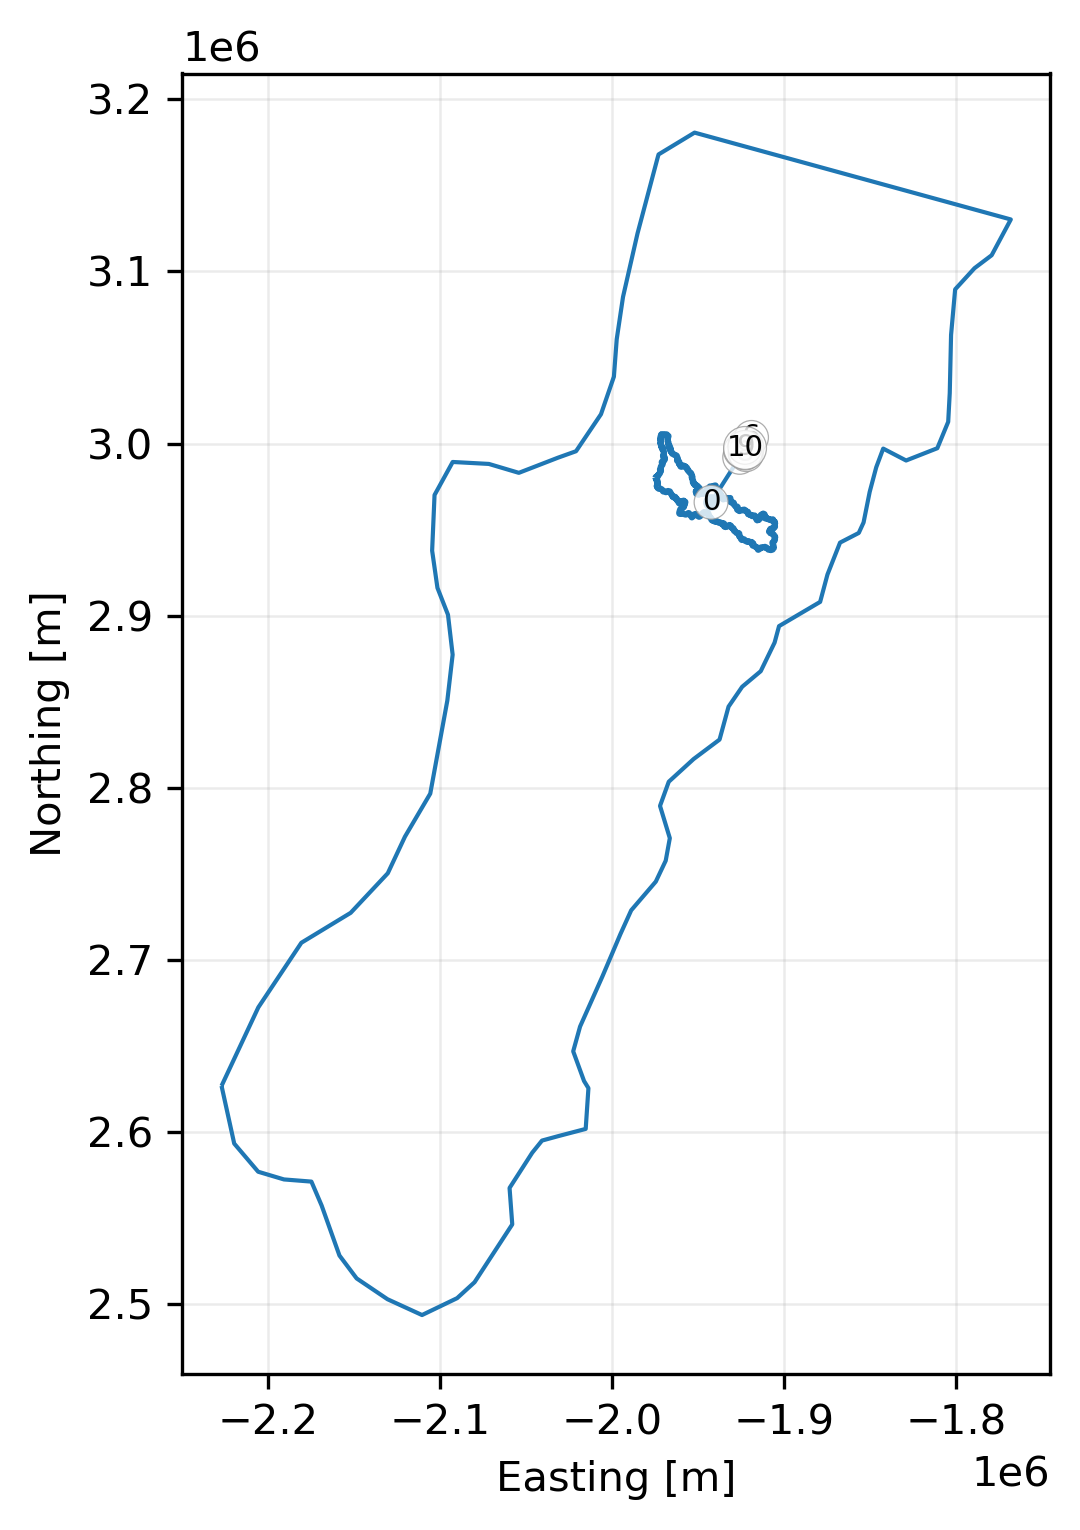

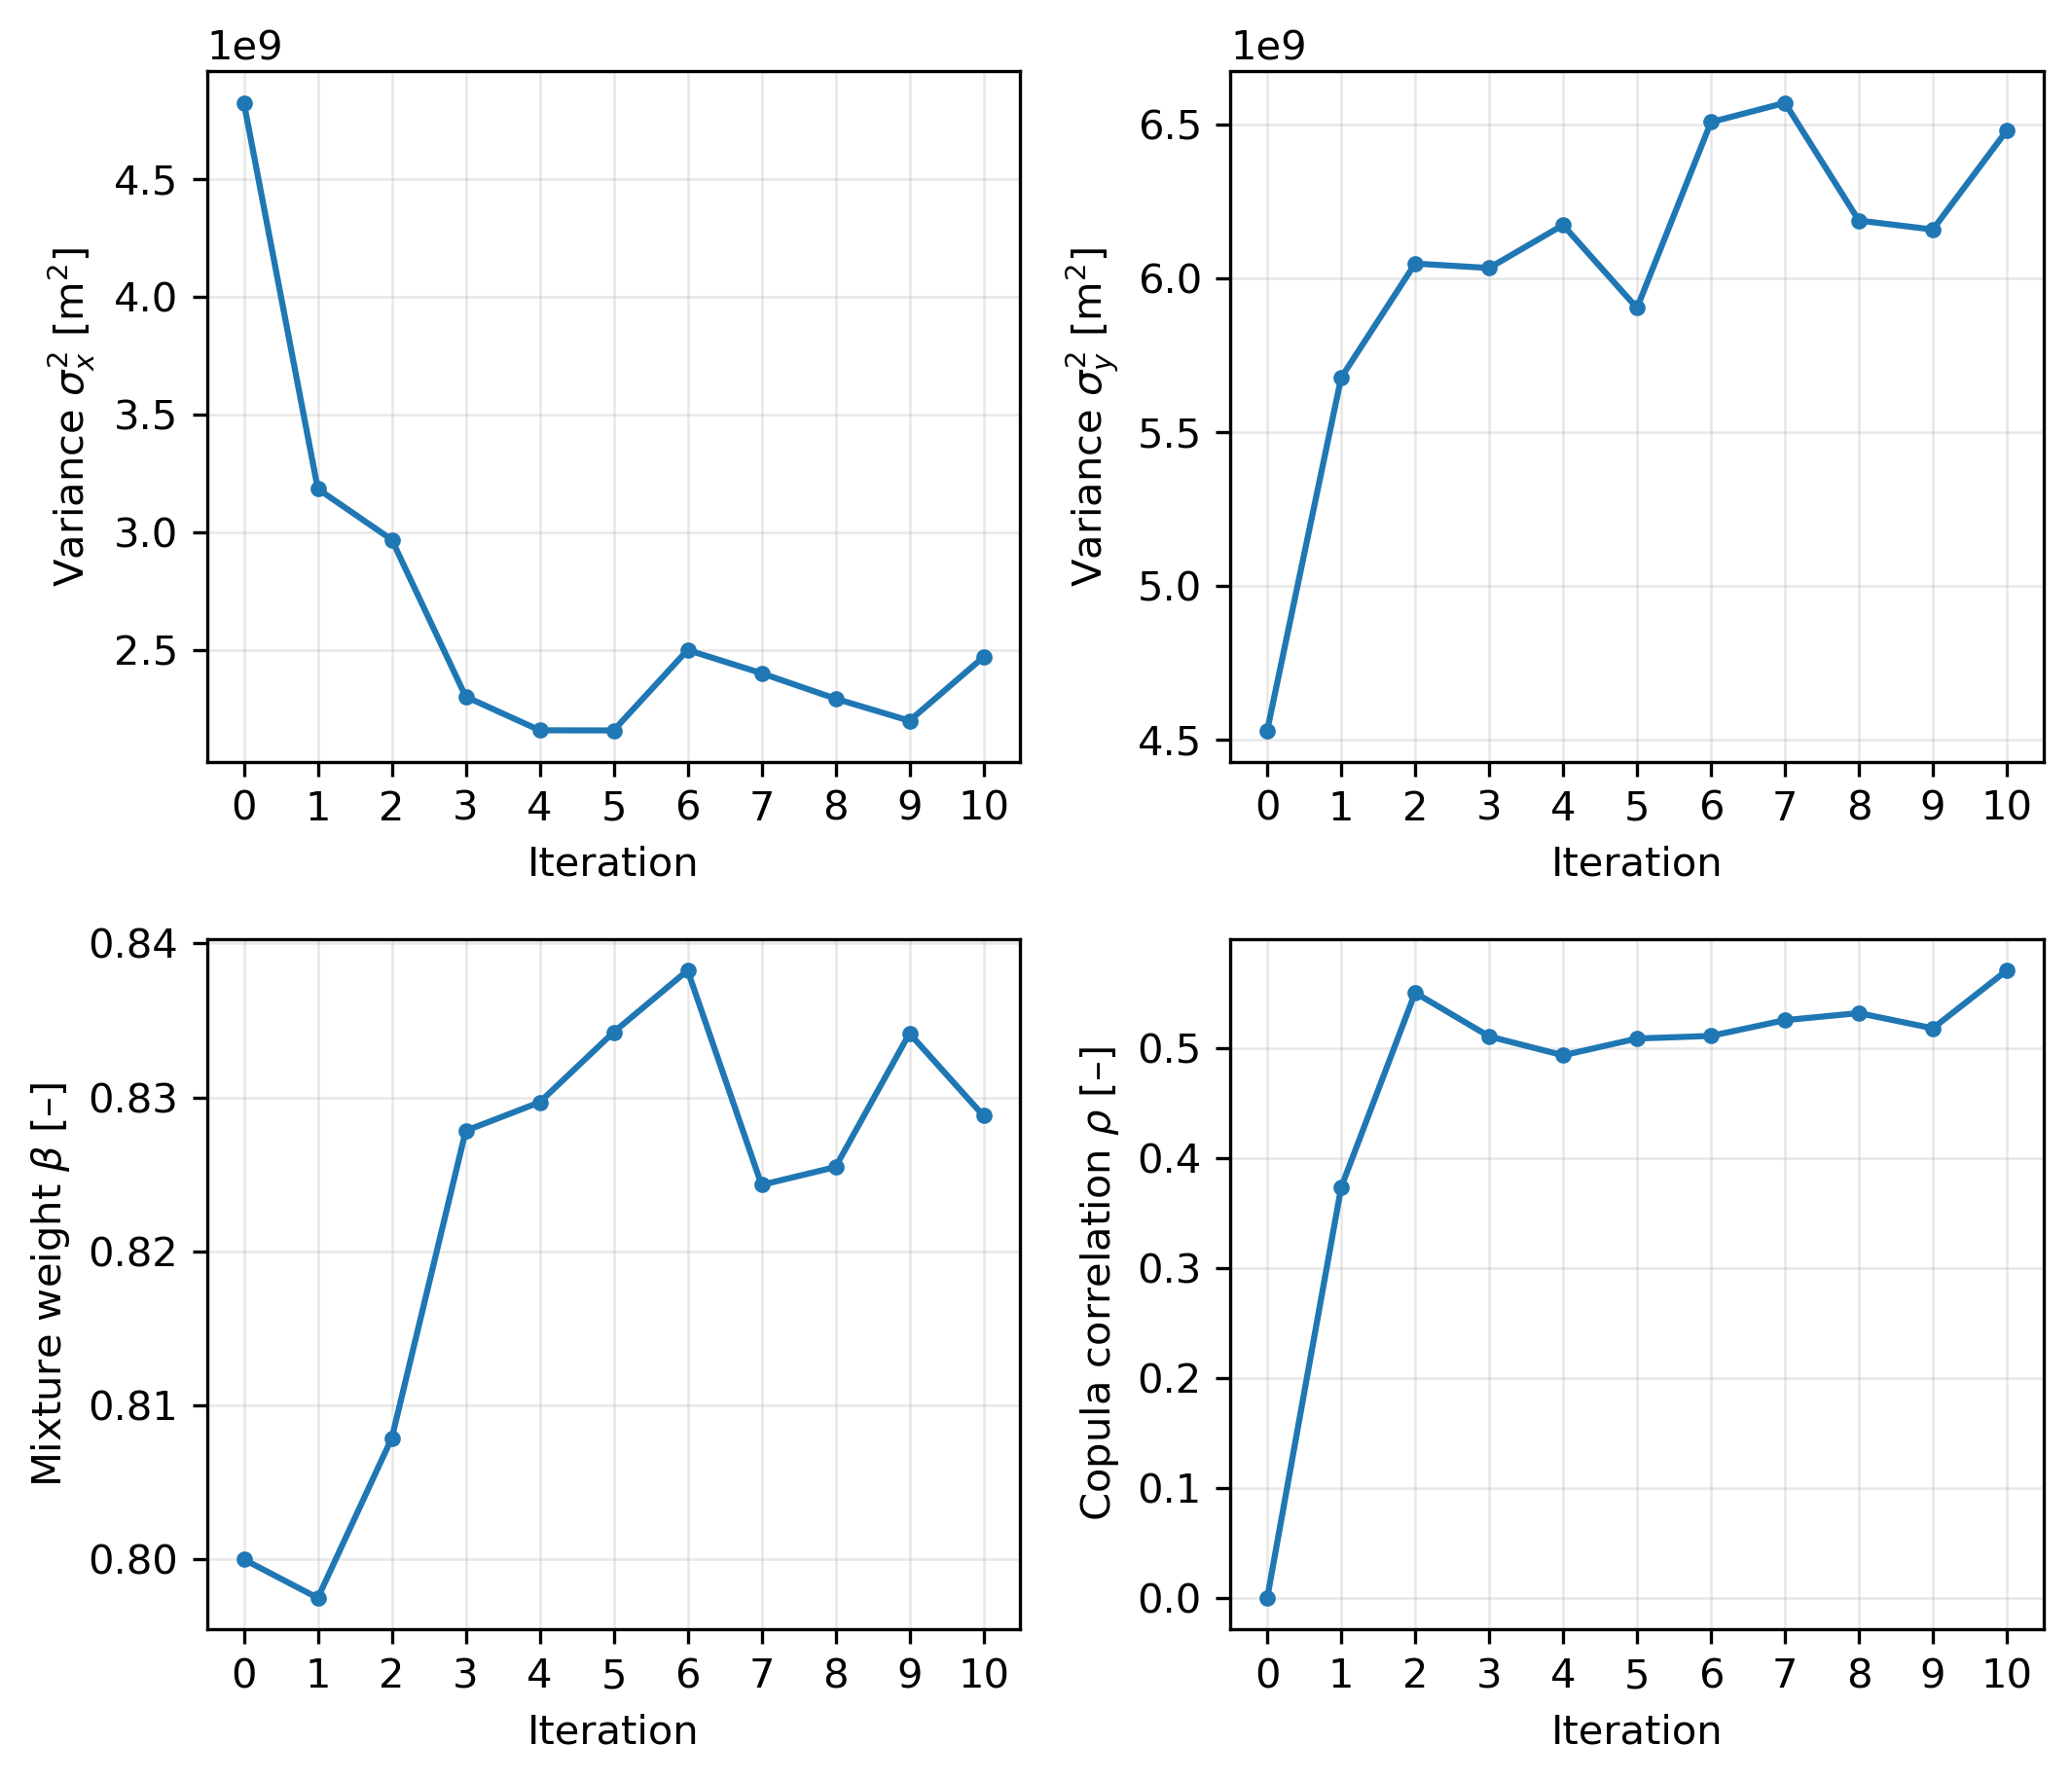

In [177]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="duwamish_ais")

In [178]:
final_df = sampler.sample_final(n=10000, num_realizations=50, with_depths=True)

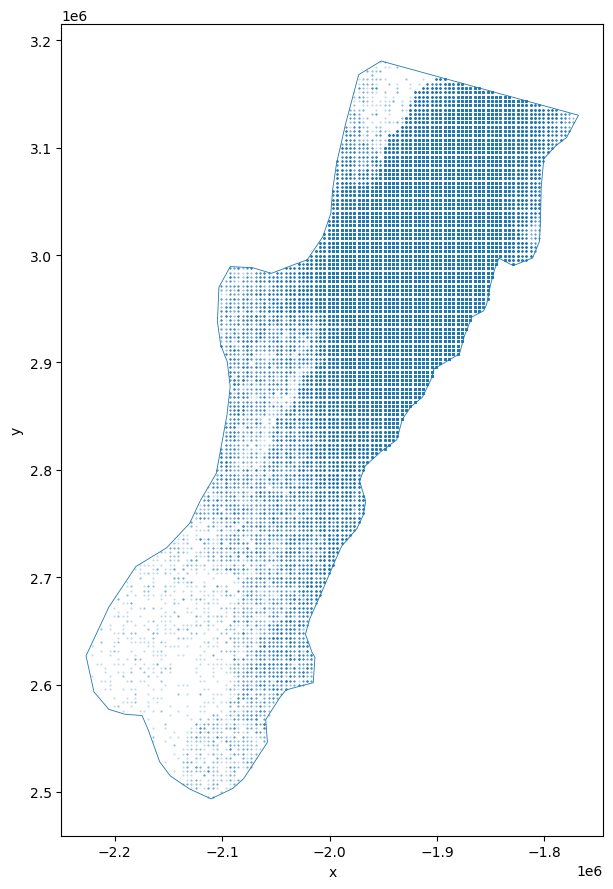

In [179]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [180]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=False
)

In [181]:
m = metrics(summaries["Duwamish"],adaptive_summary)
m

n_points  rp_min_used  rp_max_used  rmse_mean  rmse_median  rmse_ci95_low  \
0      1999          2.0       2000.0   0.183915     0.165616        0.14212   

   rmse_ci95_high  rmse_ci90_low  rmse_ci90_high   me_mean  ...  me_ci95_low  \
0         0.61013       0.188702        0.339074 -0.172186  ...    -0.111031   

   me_ci95_high  me_ci90_low  me_ci90_high  diff_at_maxrp_mean  \
0     -0.496247     -0.09867     -0.274959           -0.334488   

   diff_at_maxrp_median  diff_at_maxrp_ci95_low  diff_at_maxrp_ci95_high  \
0             -0.490971               -0.049034                -0.509139   

   diff_at_maxrp_ci90_low  diff_at_maxrp_ci90_high  
0                 0.07727                -0.589753  

[1 rows x 21 columns]

In [182]:
adaptive_summary

RP    mean_in  median_in  ci90_low_in  ci90_high_in  ci95_low_in  \
0        2   6.081943   6.089403     5.987944      6.189318     5.965320   
1        3   6.883825   6.886779     6.773420      7.008641     6.769898   
2        4   7.386787   7.413272     7.212056      7.547649     7.196281   
3        5   7.759691   7.764531     7.559059      7.922668     7.530855   
4        6   8.064785   8.055851     7.861385      8.264027     7.852631   
...    ...        ...        ...          ...           ...          ...   
1994  1996  14.337605  14.407904    13.290471     15.430978    13.084472   
1995  1997  14.338160  14.407985    13.290593     15.431790    13.084708   
1996  1998  14.338716  14.408067    13.290715     15.432602    13.084943   
1997  1999  14.339271  14.408148    13.290838     15.433414    13.085179   
1998  2000  14.339827  14.408229    13.290960     15.434226    13.085415   

      ci95_high_in  n_realizations  n_samples_per_realization  
0         6.207290              50                      10000  
1         7.052748              50                      10000  
2         7.576916              50                      10000  
3         7.986525              50                      10000  
4         8.294123              50                      10000  
...            ...             ...                        ...  
1994     15.510963              50                      10000  
1995     15.512065              50                      10000  
1996     15.513167              50                      10000  
1997     15.514269              50                      10000  
1998     15.515371              50                      10000  

[1999 rows x 9 columns]

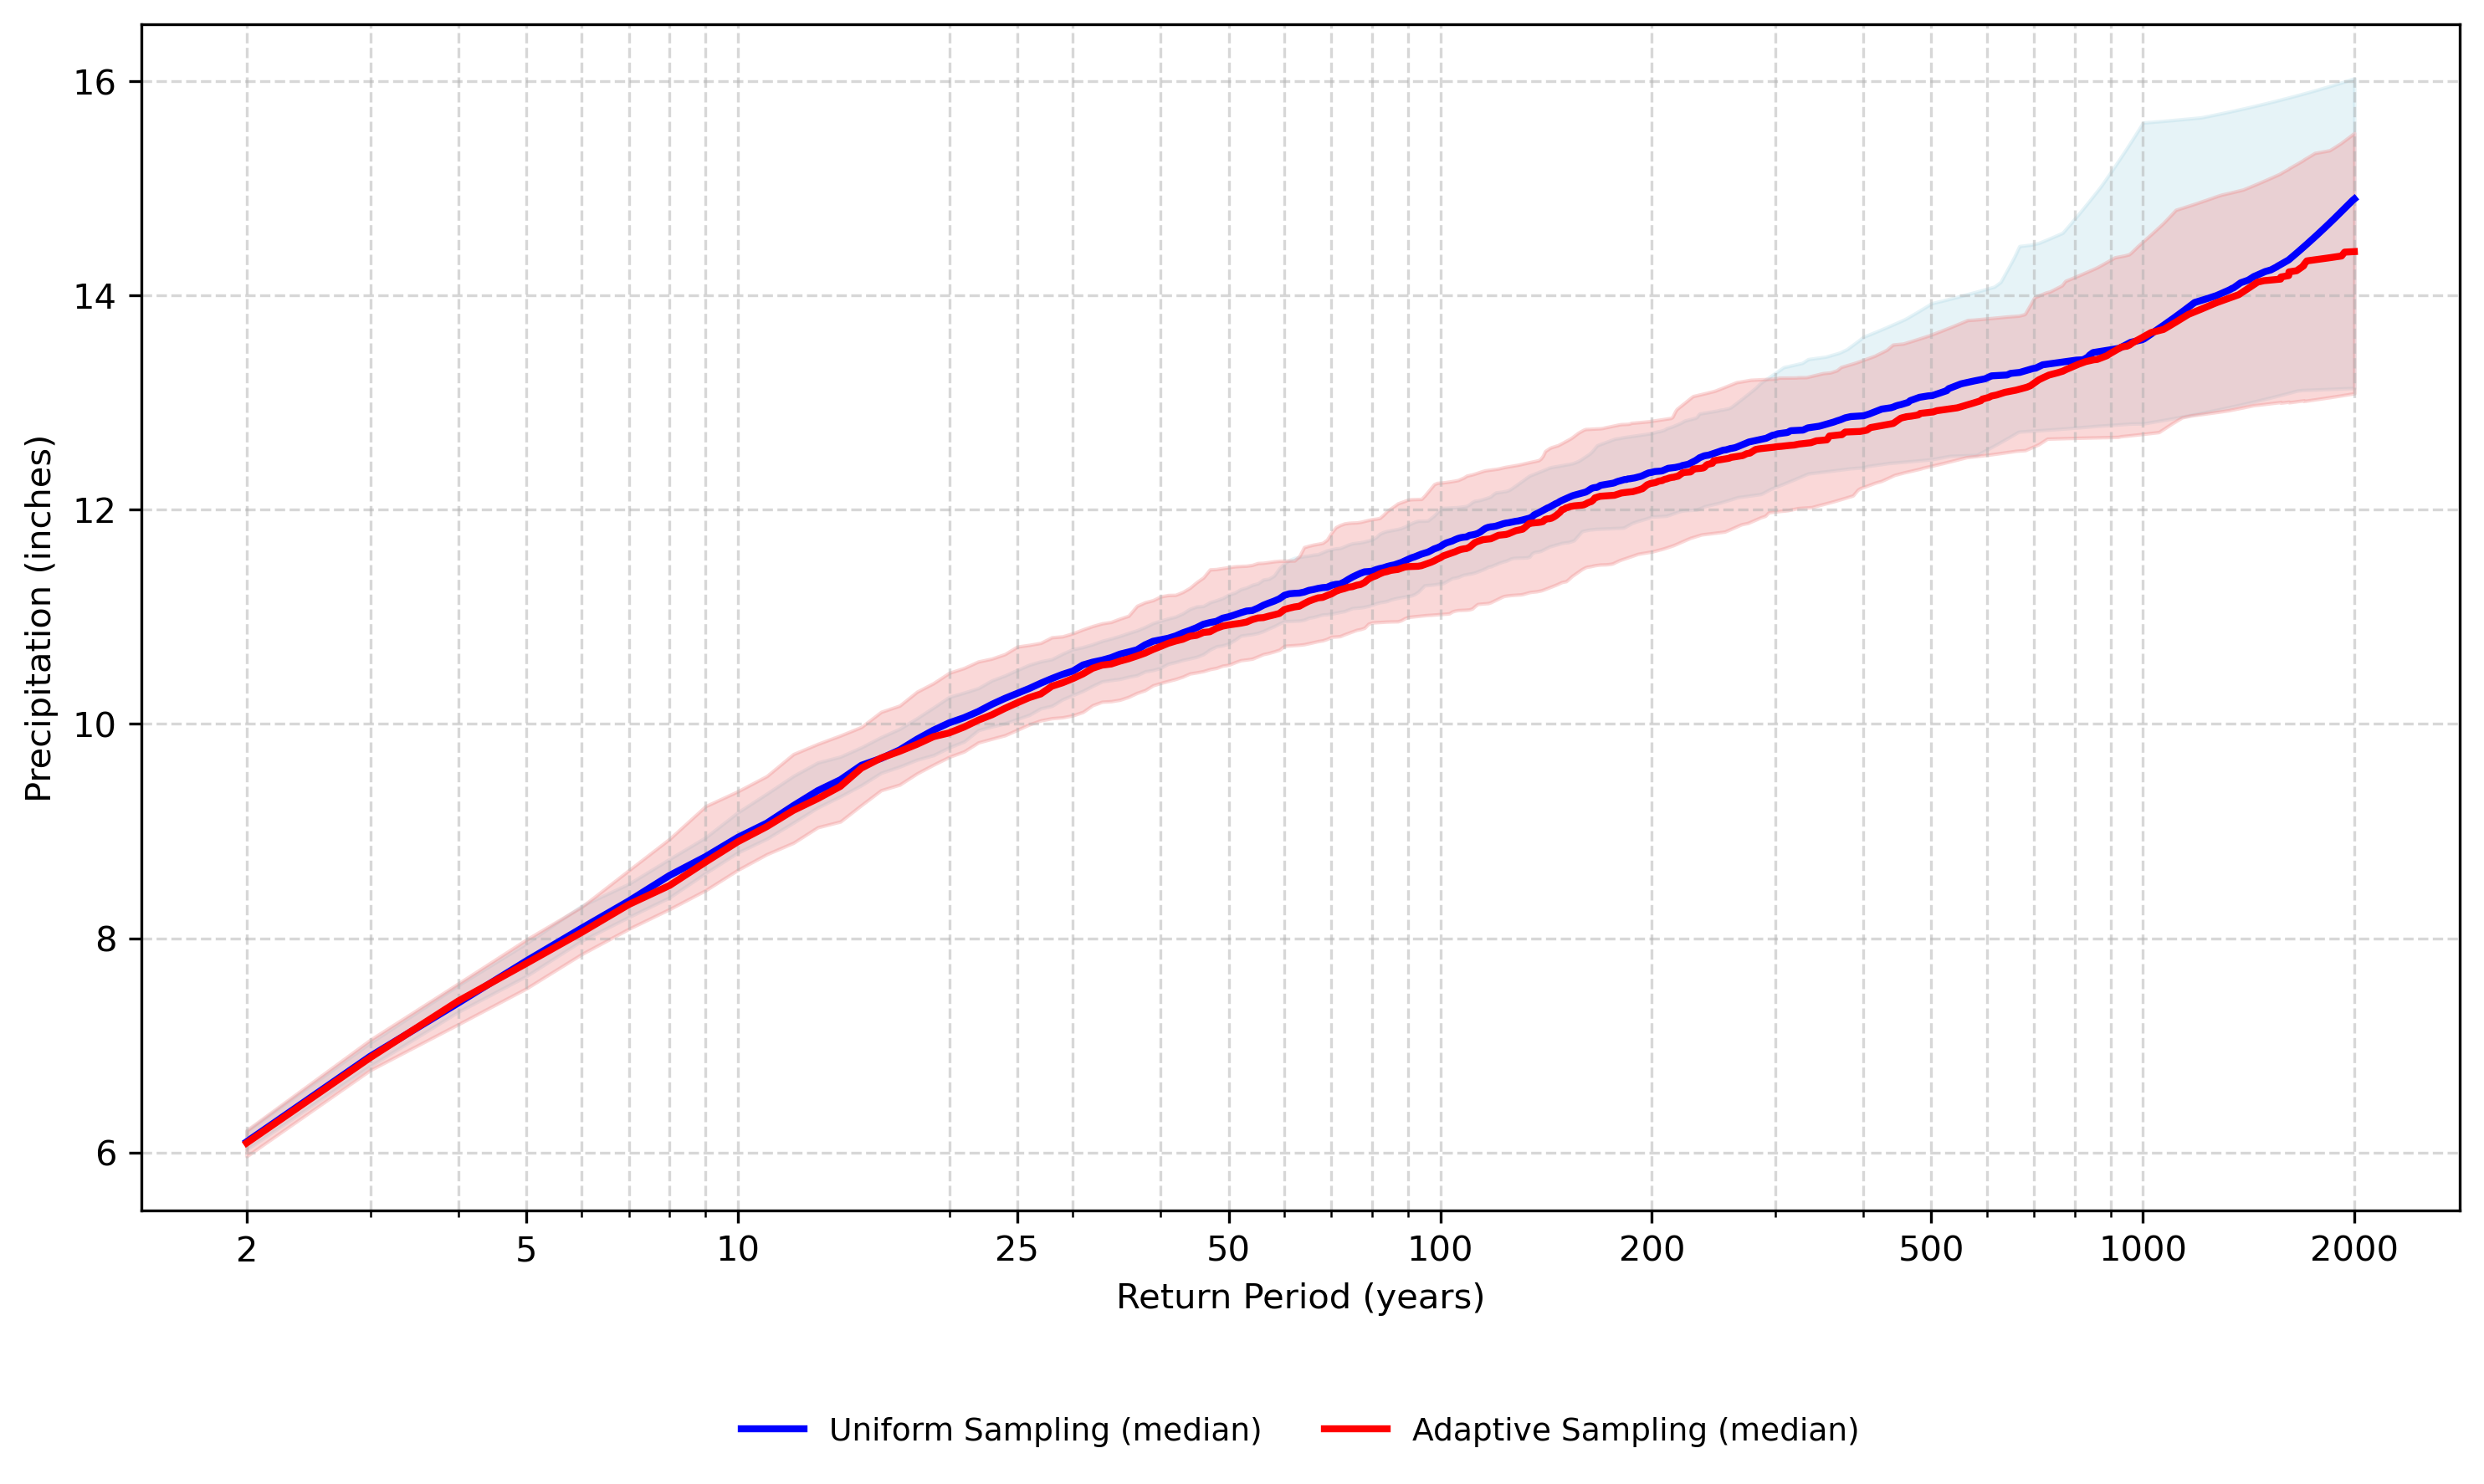

In [183]:
plot_two_return_period_summaries(
    summary1= summaries["Duwamish"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)

In [184]:
loc = Path(f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}")
final_df.to_parquet(loc / "adaptive_depths.pq", index=False)
adaptive_summary.to_parquet(loc / "adaptive_summary.pq", index=False)

In [119]:
watershed = watersheds["Denton"]
watershed_name = "Denton"

In [120]:
params = AdaptParams(
    mu_x_n=watershed.watershed_stats["x"],
    mu_y_n=watershed.watershed_stats["y"],
    sd_x_n=watershed.watershed_stats["range_x"],
    sd_y_n=watershed.watershed_stats["range_y"],

    mu_x_w=watershed.domain_stats["x"],
    mu_y_w=watershed.domain_stats["y"],
    sd_x_w=watershed.domain_stats["range_x"]/np.sqrt(12),
    sd_y_w=watershed.domain_stats["range_y"]/np.sqrt(12),

    rho_n=0,      # correlation narrow
    rho_w=0,       # correlation wide
    mix=0.8,         # initial mixture weight for narrow
    alpha = 0.75
)

sampler = AdaptiveMixtureSampler(
    data=watershed,                   
    params=params,
    precip_cube=watershed.cumulative_precip,
    seed=42
)

# Adapt does NOT take data or seed
history = sampler.adapt(num_iterations=10, samples_per_iter=1000, depth_threshold=50.8)

In [121]:
history

iter     n  updated       mix         mu_x_n        mu_y_n         sd_x_n  \
0      0     0        0  0.800000 -133671.225227  1.132086e+06   72093.816157   
1      1  1000        1  0.774240 -134584.783478  1.120045e+06   95992.325783   
2      2  1000        1  0.767998 -116360.996228  1.120149e+06   98620.942302   
3      3  1000        1  0.794749 -112650.483350  1.122840e+06  104085.549814   
4      4  1000        1  0.807726 -108288.908911  1.124747e+06  107187.024013   
5      5  1000        1  0.804447  -98560.666770  1.114377e+06  107769.369786   
6      6  1000        1  0.789306  -96265.164083  1.115362e+06  115349.443948   
7      7  1000        1  0.777943 -104058.030033  1.108762e+06  115113.616722   
8      8  1000        1  0.810284  -95920.013278  1.108937e+06  115767.403856   
9      9  1000        1  0.813405  -95182.613925  1.111235e+06  116502.215450   
10    10  1000        1  0.832434  -88658.031649  1.117509e+06  116935.064879   

          sd_y_n     rho_n  beta_hat_reward  
0   82380.632370  0.000000              NaN  
1   87516.946274  0.292914         0.714133  
2   91695.576674  0.347015         0.753432  
3   91017.413515  0.392536         0.857168  
4   92042.548264  0.417413         0.838008  
5   94794.461897  0.339639         0.796795  
6   99280.638846  0.331880         0.753977  
7   98258.977028  0.333476         0.751429  
8   97774.437826  0.272698         0.885745  
9   98393.000293  0.264459         0.820690  
10  96705.844139  0.215712         0.876832

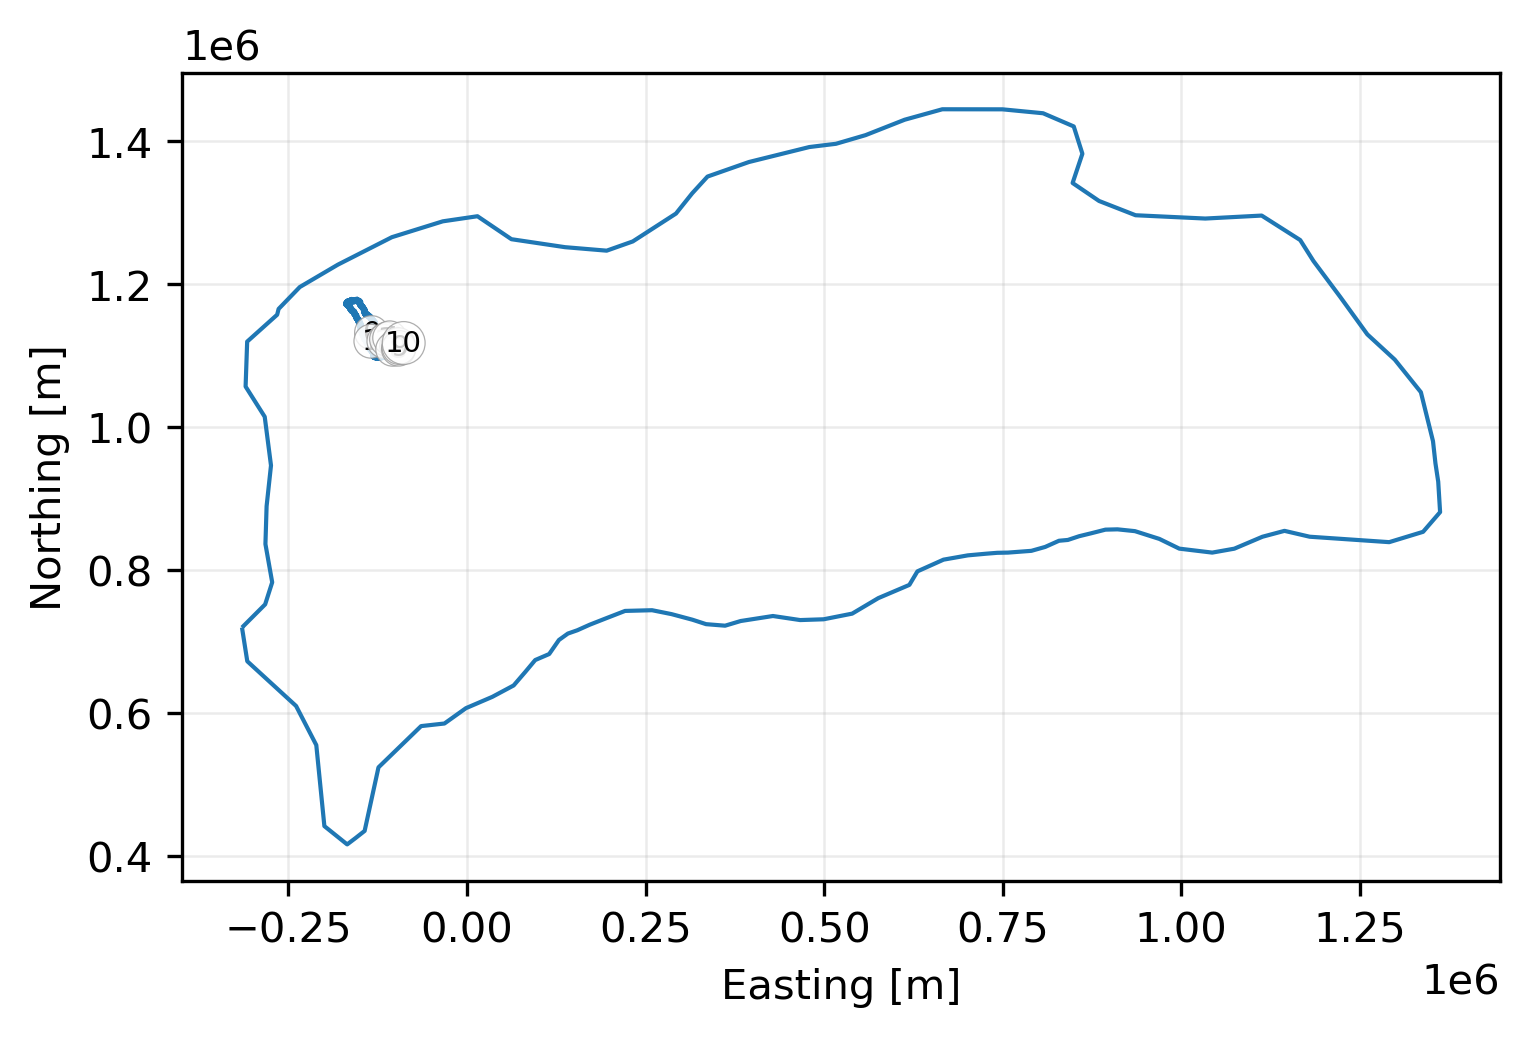

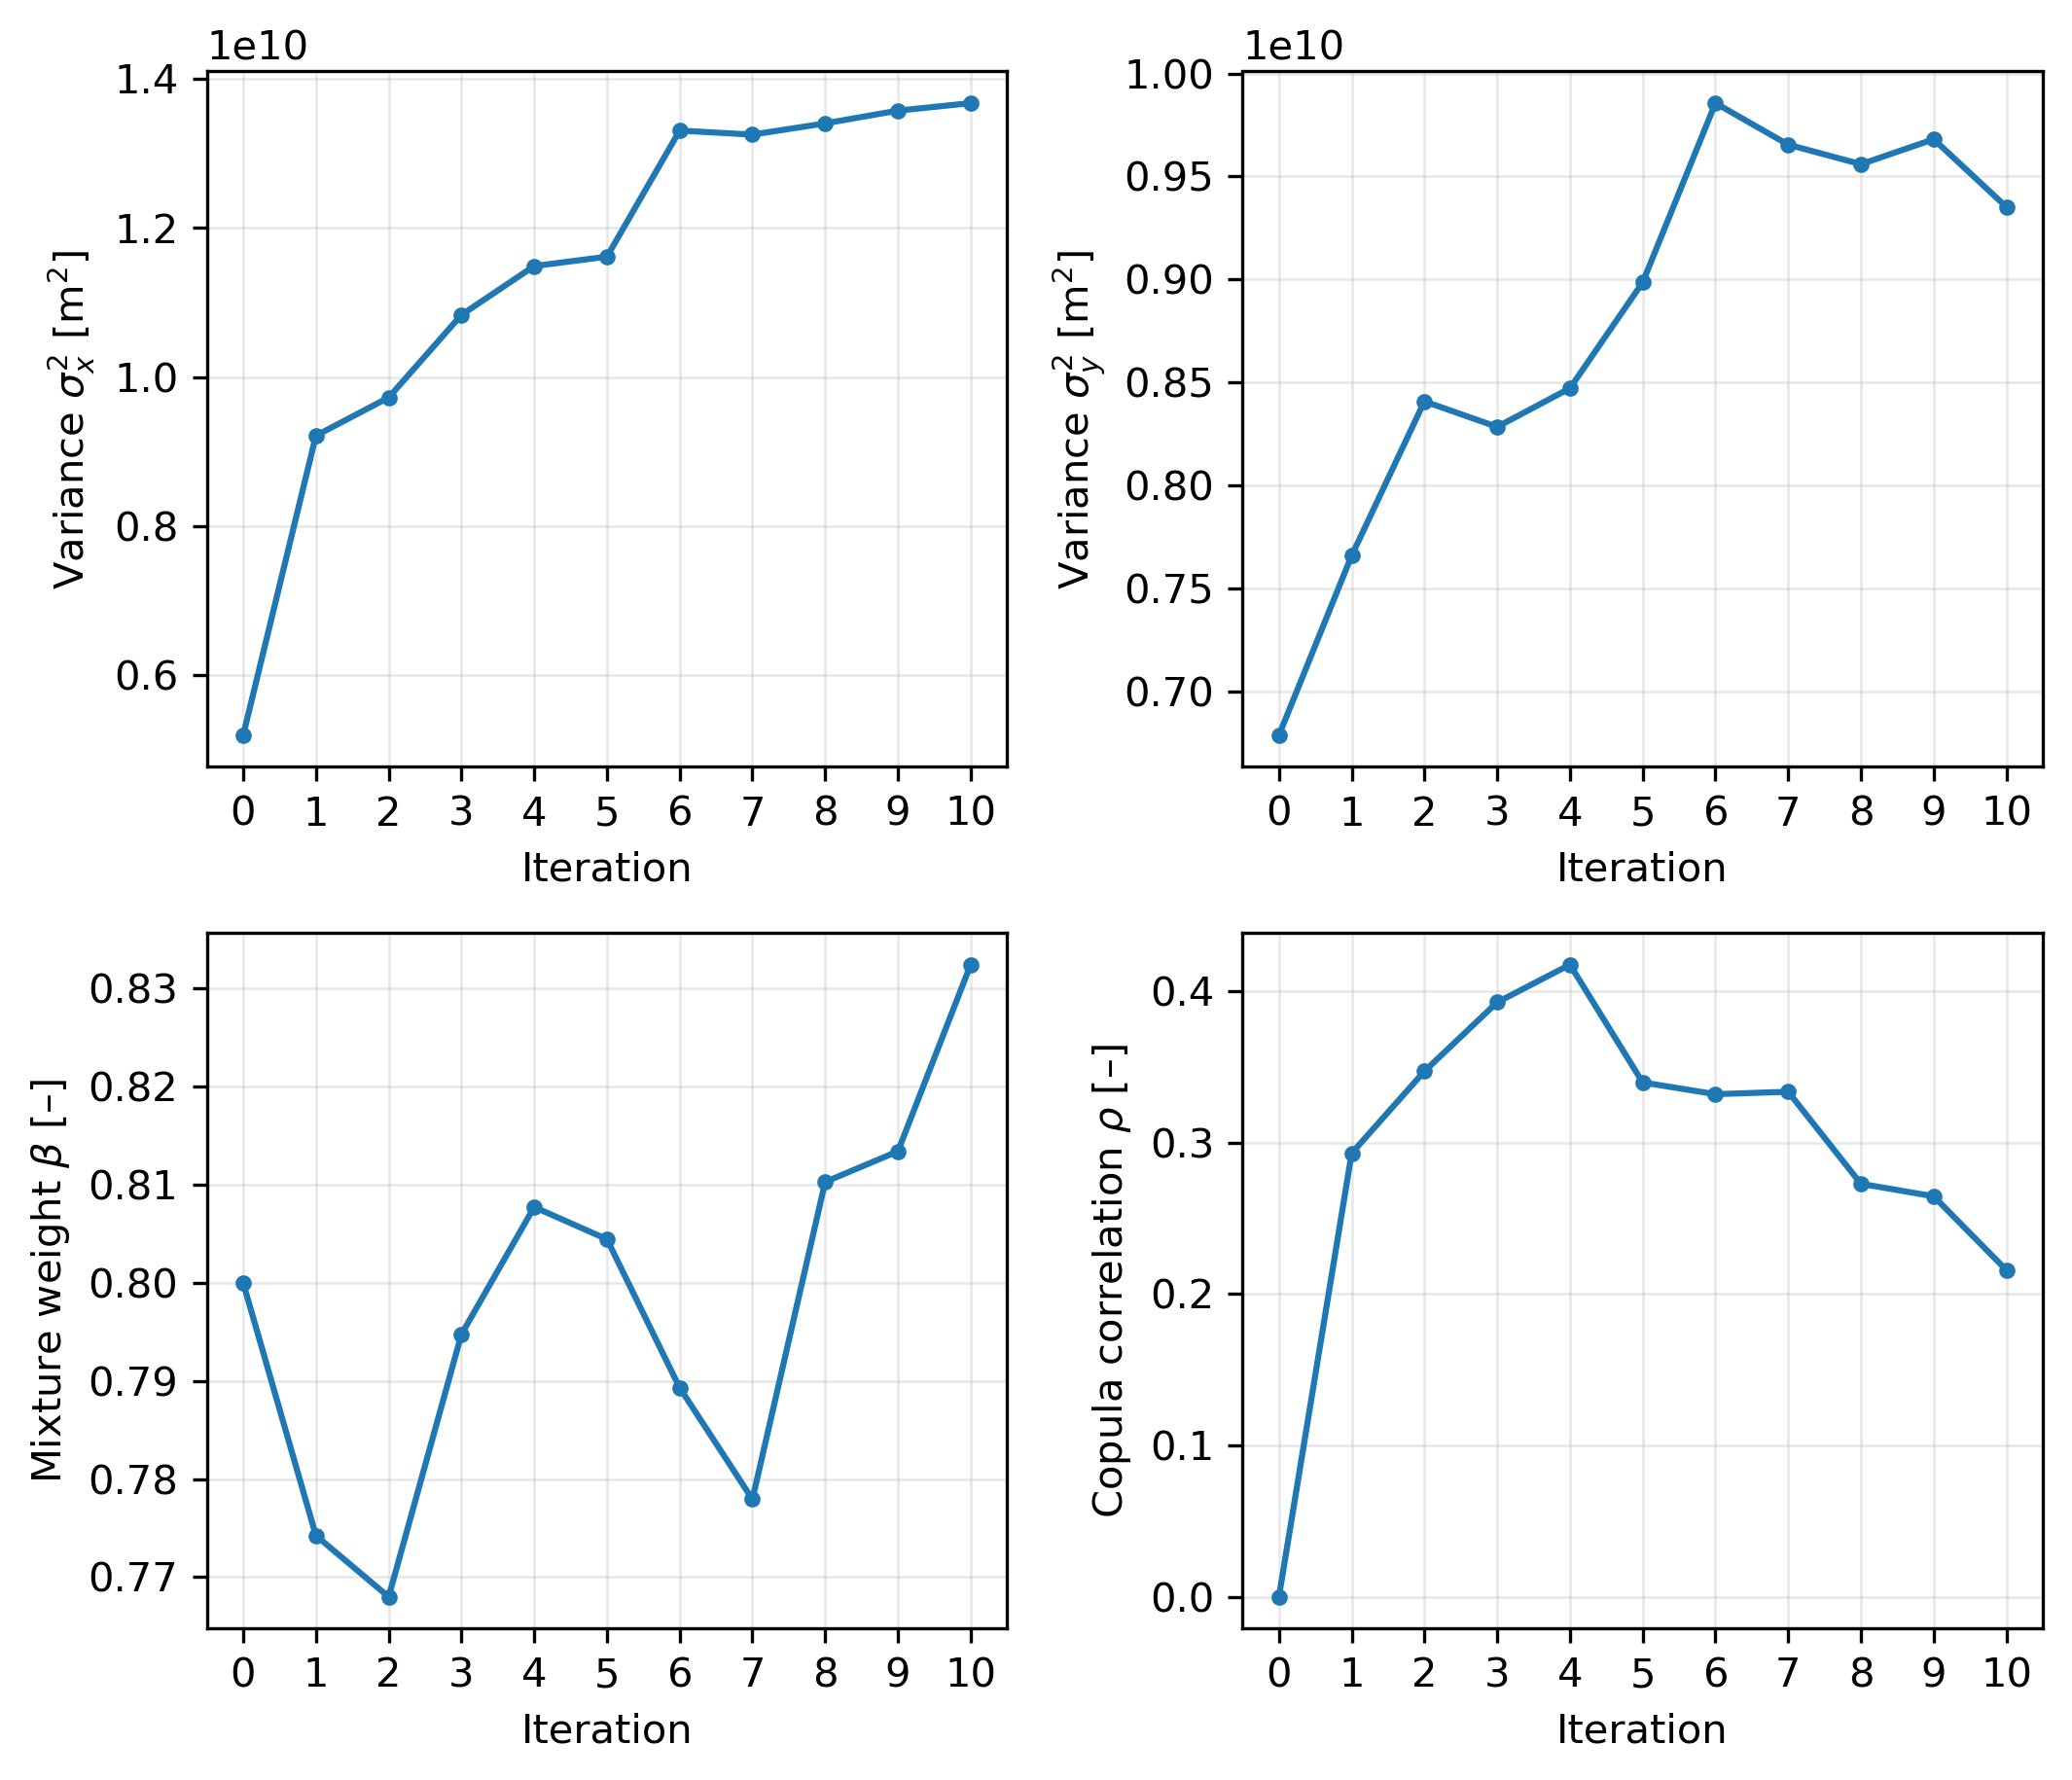

In [122]:
plot_adaptive_evolution(history, watershed.watershed_gdf, watershed.domain_gdf, save=False, prefix="denton_ais")

In [123]:
final_df = sampler.sample_final(n=10000, num_realizations=50, with_depths=True)

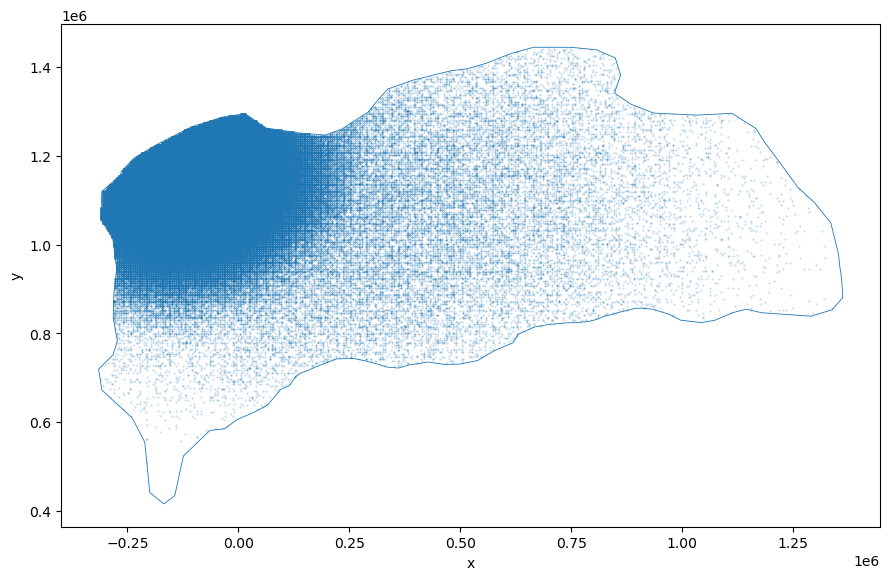

In [124]:
ax = watershed.domain_gdf.boundary.plot(linewidth=0.6, figsize=(9,9))
plt.scatter(final_df.newx, final_df.newy, s=0.2, alpha=0.3, rasterized=True)
plt.gca().set_aspect("equal")
plt.xlabel("x"); plt.ylabel("y"); plt.tight_layout()
plt.show()

In [125]:
adaptive_summary = summarize_depths_by_return_period(
    df=final_df,       
    precip_col="precip_avg_mm",
    exc_col="exc_prb",
    realization_col="realization",
    k=10.0,                            
    rp_min=2,
    rp_max_cap=2000,
    use_common_min=True
)

In [126]:
m = metrics(summaries["Denton"],adaptive_summary)
m

n_points  rp_min_used  rp_max_used  rmse_mean  rmse_median  rmse_ci95_low  \
0      1999          2.0       2000.0    0.91045     1.465898       1.546024   

   rmse_ci95_high  rmse_ci90_low  rmse_ci90_high   me_mean  ...  me_ci95_low  \
0        0.938605       1.469663        0.532142  0.724102  ...     1.324004   

   me_ci95_high  me_ci90_low  me_ci90_high  diff_at_maxrp_mean  \
0     -0.361445     1.251934     -0.258738            0.841225   

   diff_at_maxrp_median  diff_at_maxrp_ci95_low  diff_at_maxrp_ci95_high  \
0              0.911935                2.419333                -0.414898   

   diff_at_maxrp_ci90_low  diff_at_maxrp_ci90_high  
0                2.272136                -0.266822  

[1 rows x 21 columns]

In [127]:
adaptive_summary

RP    mean_in  median_in  ci90_low_in  ci90_high_in  ci95_low_in  \
0        2   5.340469   5.335978     5.188459      5.499025     5.141641   
1        3   6.163010   6.161705     6.021238      6.290301     5.993871   
2        4   6.703959   6.714227     6.555719      6.837039     6.518114   
3        5   7.082103   7.103529     6.918343      7.252310     6.903859   
4        6   7.384371   7.404061     7.225890      7.533660     7.197767   
...    ...        ...        ...          ...           ...          ...   
1994  1996  28.454937  29.349615    21.627251     32.418740    20.930222   
1995  1997  28.456602  29.351058    21.629534     32.419448    20.932113   
1996  1998  28.458180  29.352500    21.631817     32.420155    20.934003   
1997  1999  28.459755  29.353942    21.634100     32.420863    20.935893   
1998  2000  28.461331  29.355385    21.636384     32.421570    20.937783   

      ci95_high_in  n_realizations  n_samples_per_realization  
0         5.536866              50                      10000  
1         6.334836              50                      10000  
2         6.847949              50                      10000  
3         7.260373              50                      10000  
4         7.571949              50                      10000  
...            ...             ...                        ...  
1994     32.622937              50                      10000  
1995     32.623318              50                      10000  
1996     32.623700              50                      10000  
1997     32.624081              50                      10000  
1998     32.624463              50                      10000  

[1999 rows x 9 columns]

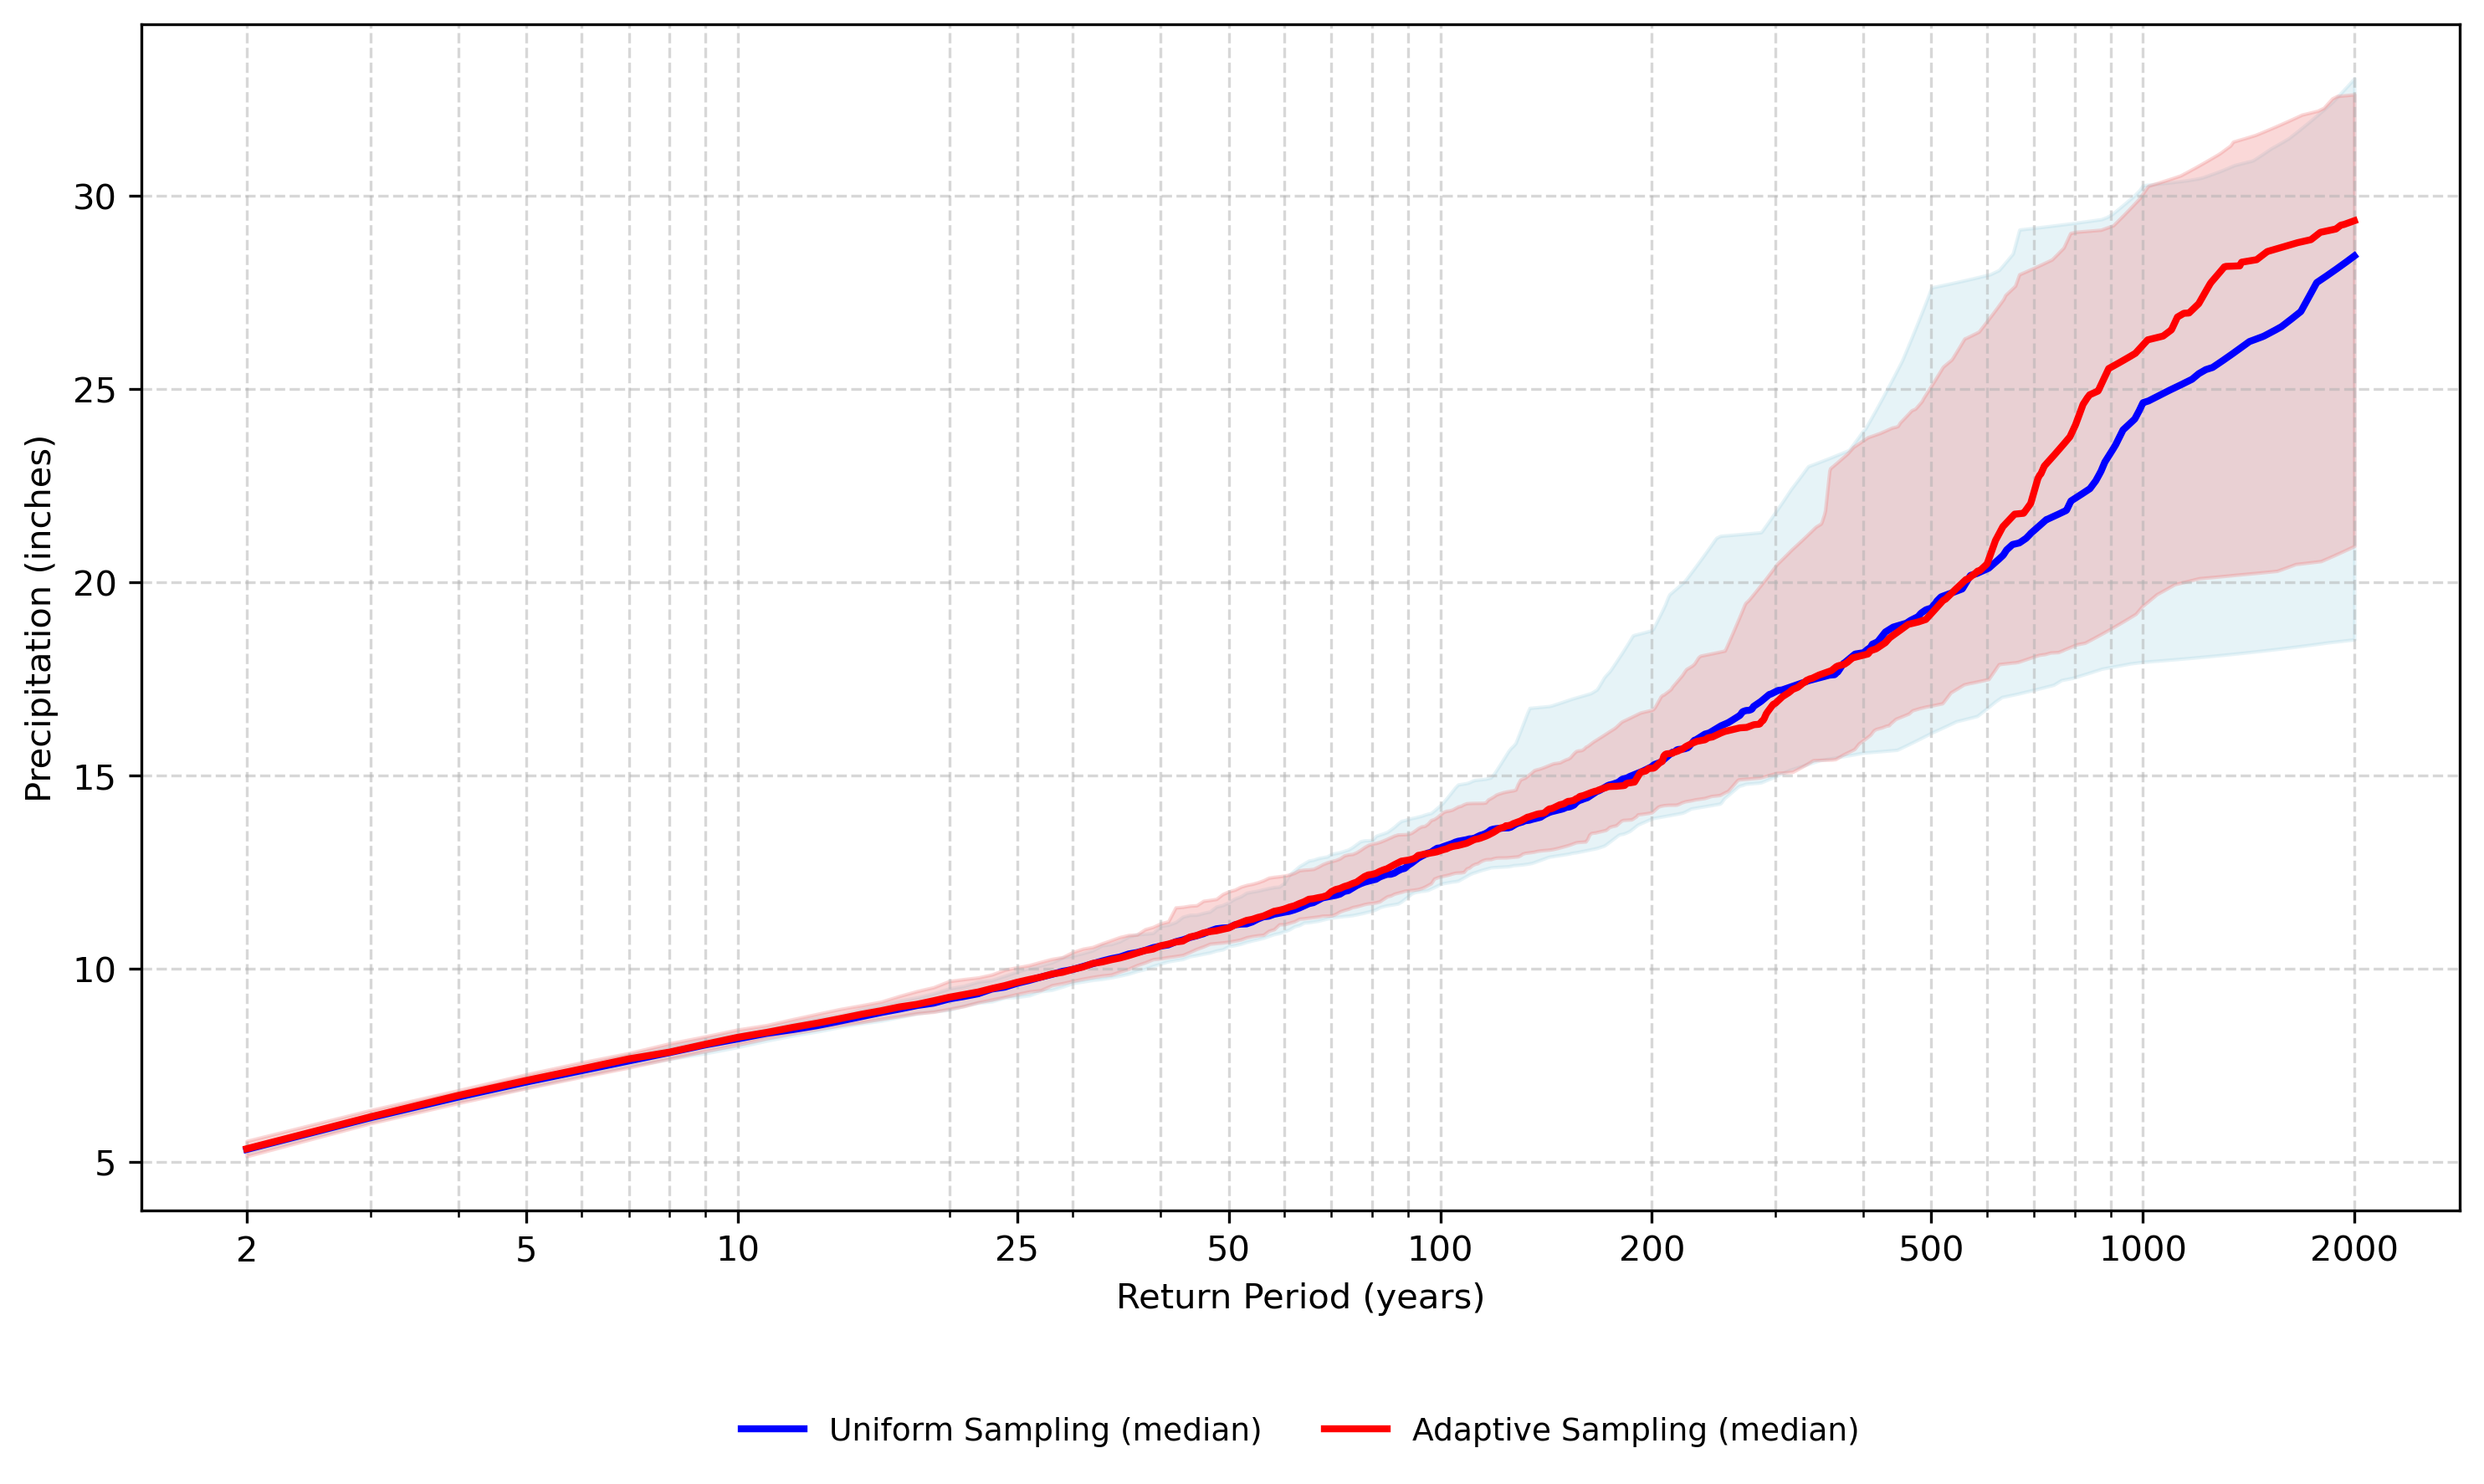

In [128]:
plot_two_return_period_summaries(
    summary1= summaries["Denton"],          # your first summary DataFrame
    summary2=adaptive_summary,       # your second summary DataFrame
    label1="Uniform Sampling",
    label2="Adaptive Sampling",
    title=""
)

In [129]:
loc = Path(f"/workspaces/Importance-Sampling-for-SST/data/2_production/{watershed_name}")
final_df.to_parquet(loc / "adaptive_depths.pq", index=False)
adaptive_summary.to_parquet(loc / "adaptive_summary.pq", index=False)

Combined plot

In [144]:
adaptive_summary

RP   mean_in  median_in  ci90_low_in  ci90_high_in  ci95_low_in  \
0        2  2.712849   2.709695     2.680582      2.749598     2.677395   
1        3  3.045379   3.045539     3.006060      3.090992     2.991030   
2        4  3.247937   3.246504     3.198521      3.295571     3.193691   
3        5  3.409379   3.410885     3.349935      3.461648     3.348292   
4        6  3.533583   3.537001     3.468239      3.587625     3.459534   
...    ...       ...        ...          ...           ...          ...   
1959  1961  5.643030   5.670146     5.479648      5.735386     5.440095   
1960  1962  5.643103   5.670177     5.479790      5.735453     5.440174   
1961  1963  5.643176   5.670207     5.479932      5.735521     5.440252   
1962  1964  5.643249   5.670238     5.480073      5.735588     5.440331   
1963  1965  5.643322   5.670269     5.480215      5.735655     5.440409   

      ci95_high_in  n_realizations  n_samples_per_realization  
0         2.752300              50                      11000  
1         3.099222              50                      11000  
2         3.297864              50                      11000  
3         3.466095              50                      11000  
4         3.594462              50                      11000  
...            ...             ...                        ...  
1959      5.739076              50                      11000  
1960      5.739112              50                      11000  
1961      5.739148              50                      11000  
1962      5.739184              50                      11000  
1963      5.739220              50                      11000  

[1964 rows x 9 columns]

/tmp/ipykernel_19532/2711574430.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


Saved: /workspaces/Importance-Sampling-for-SST/data/2_production/plots/full_vs_adaptive_precip_frequency_2x2.png


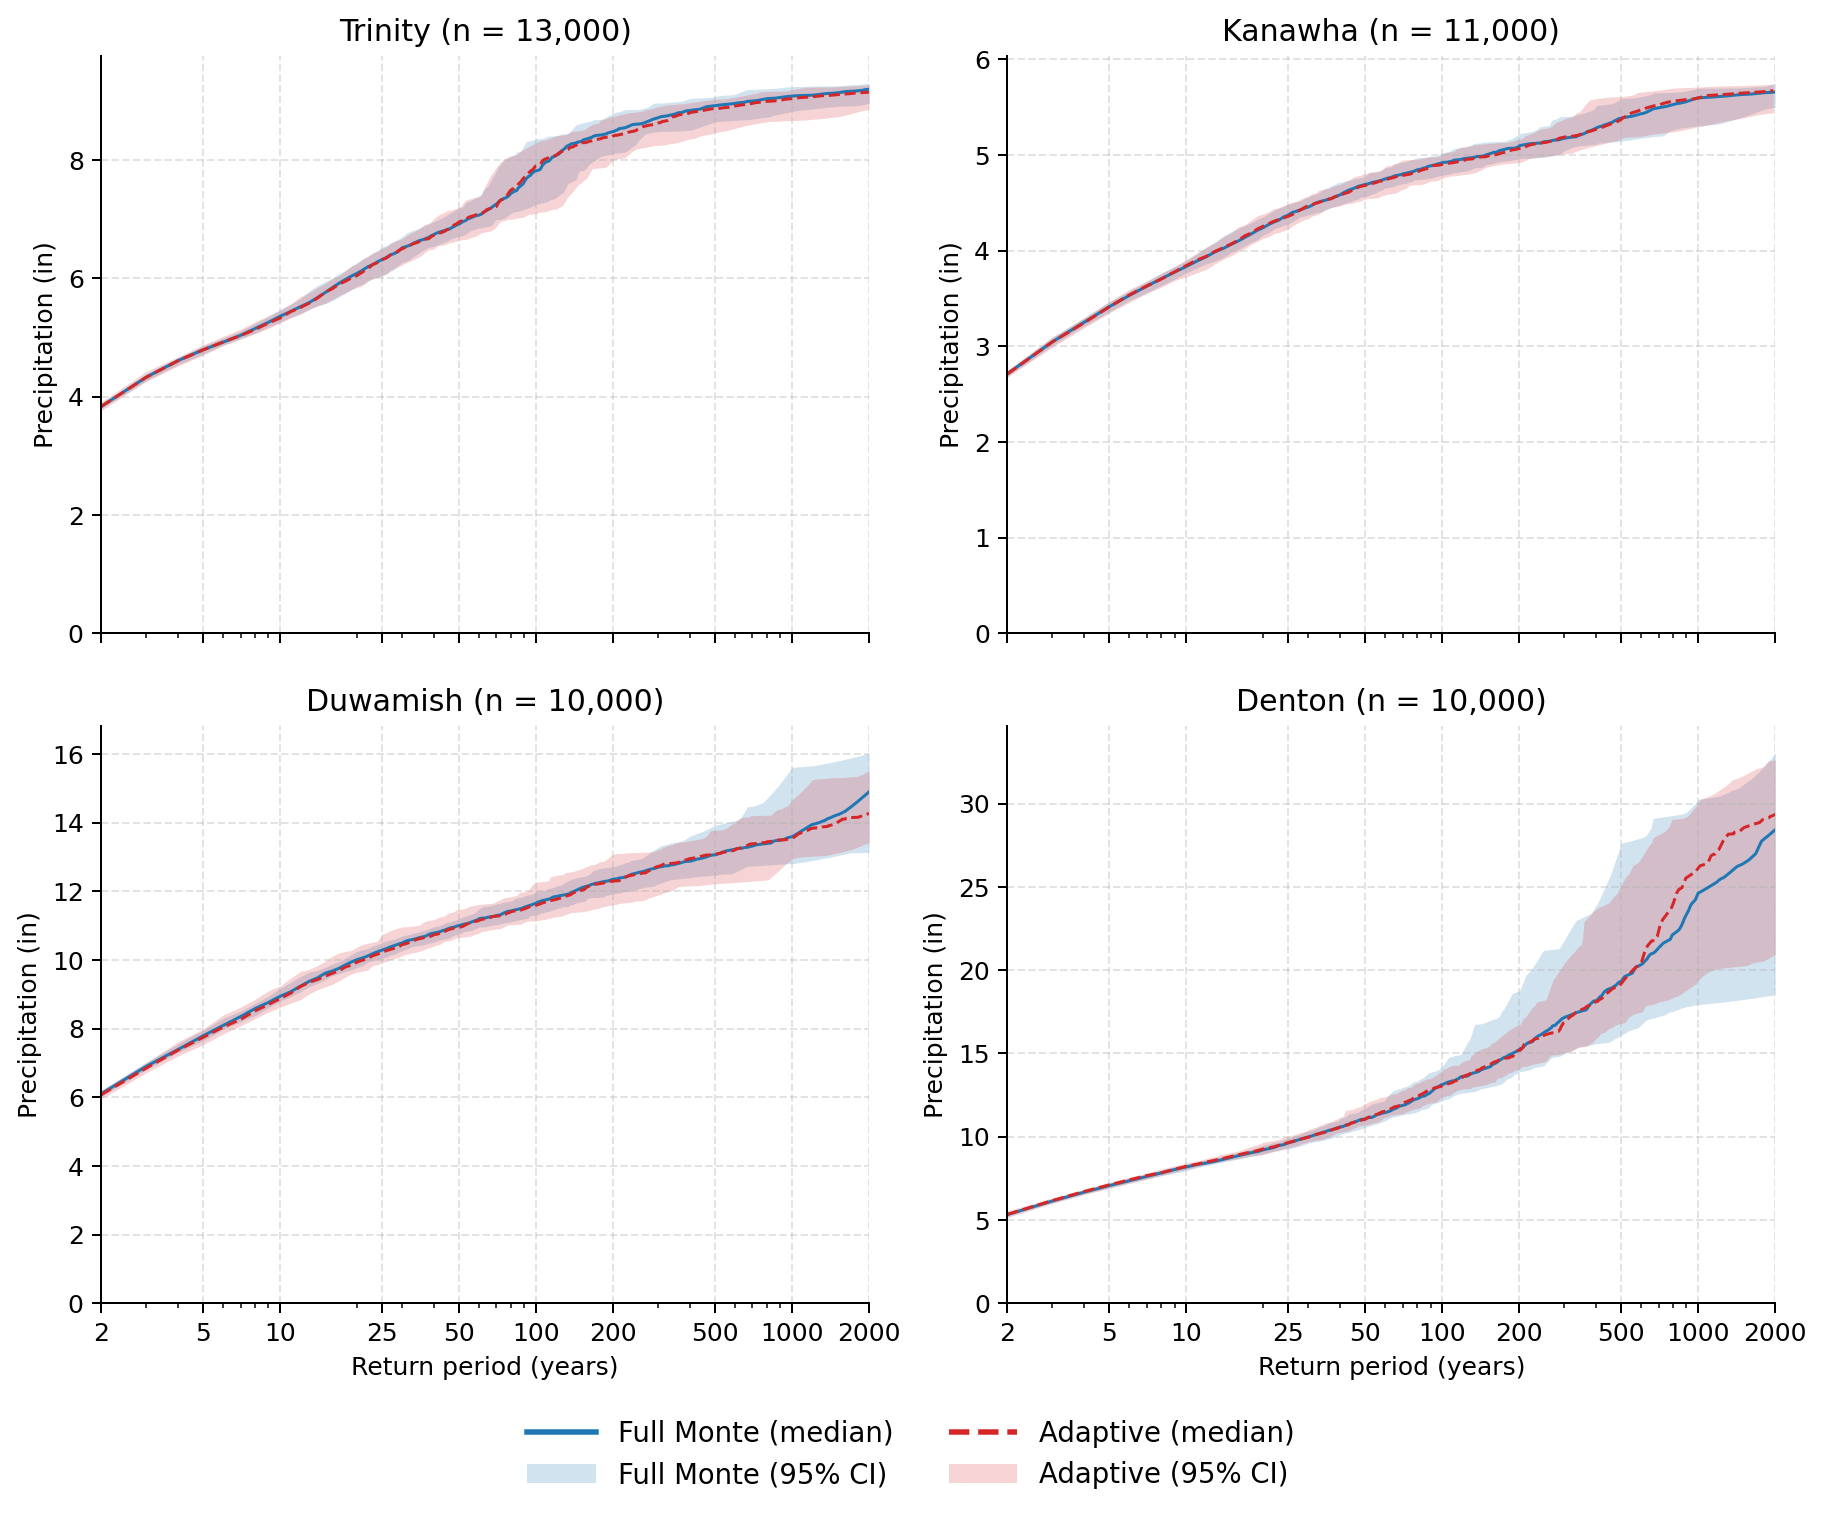

In [146]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import ScalarFormatter

# ----------------- config -----------------
base_dir = "/workspaces/Importance-Sampling-for-SST/data/2_production"
summary_filename  = "fullmonte_summary.pq"
adaptive_filename = "adaptive_summary.pq"

x_ticks = [2, 5, 10, 25, 50, 100, 200, 500, 1000, 2000]
x_min, x_max = 2, 2000

c_full     = "C0"  # blue
c_adaptive = "C3"  # red

# ----------------- load data -----------------
def load_summary_map(names, filename):
    m = {}
    for w in names:
        p = Path(base_dir) / w / filename
        df = pd.read_parquet(p)
        need = {"RP", "median_in", "ci95_low_in", "ci95_high_in"}
        missing = need - set(df.columns)
        if missing:
            raise ValueError(f"{w}: summary missing columns {missing}")
        m[w] = df.sort_values("RP")
    return m

full_map     = load_summary_map(watershed_names, summary_filename)
adaptive_map = load_summary_map(watershed_names, adaptive_filename)

# ----------------- plotting -----------------
fig = plt.figure(figsize=(12, 9), dpi=180)
gs = GridSpec(2, 2, figure=fig, wspace=0.18, hspace=0.16)

axes = []
for i, w in enumerate(watershed_names):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    axes.append(ax)

    d_full = full_map[w].copy()
    d_adap = adaptive_map[w].copy()

    # clip to RP range
    d_full = d_full[(d_full["RP"] >= x_min) & (d_full["RP"] <= x_max)]
    d_adap = d_adap[(d_adap["RP"] >= x_min) & (d_adap["RP"] <= x_max)]

    # --- Full Monte (ribbon + median) ---
    ax.fill_between(
        d_full["RP"], d_full["ci95_low_in"], d_full["ci95_high_in"],
        alpha=0.20, linewidth=0, color=c_full
    )
    ax.plot(
        d_full["RP"], d_full["median_in"],
        linewidth=1.2, color=c_full
    )

    # --- Adaptive (ribbon + median) ---
    ax.fill_between(
        d_adap["RP"], d_adap["ci95_low_in"], d_adap["ci95_high_in"],
        alpha=0.20, linewidth=0, color=c_adaptive
    )
    ax.plot(
        d_adap["RP"], d_adap["median_in"],
        linewidth=1.2, color=c_adaptive, linestyle="--"
    )

    ax.set_xscale("log")
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_ticks)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.tick_params(axis="x", which="major", length=4)
    ax.margins(x=0)

    # consistent y-limit
    ymax = np.nanmax([d_full["ci95_high_in"].max(), d_adap["ci95_high_in"].max()])
    ymin = min(np.nanmin([d_full["ci95_low_in"].min(), d_adap["ci95_low_in"].min()]), 0.0)
    ax.set_ylim(ymin, ymax * 1.05)

    ax.grid(True, which="major", axis="both", linestyle="--", alpha=0.35)

    # grab n_samples_per_iteration directly
    if "n_samples_per_realization" in d_adap.columns:
        n_val = int(d_adap["n_samples_per_realization"].iloc[0])
        title = f"{w} (n = {n_val:,})"
    else:
        title = w
    ax.set_title(title, fontsize=12, pad=6)
    ax.set_ylabel("Precipitation (in)")

# show x tick labels only on bottom row
for ax in axes[:2]:
    ax.set_xlabel("")
    ax.set_xticklabels([])
for ax in axes[2:]:
    ax.set_xlabel("Return period (years)")

# remove top/right spines
for ax in axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# -------- shared legend --------
legend_handles = [
    Line2D([0], [0], color=c_full, lw=2.2, label="Full Monte (median)"),
    Patch(facecolor=c_full, alpha=0.20, label="Full Monte (95% CI)"),
    Line2D([0], [0], color=c_adaptive, lw=2.2, linestyle="--", label="Adaptive (median)"),
    Patch(facecolor=c_adaptive, alpha=0.20, label="Adaptive (95% CI)"),
]
fig.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.02),
    ncol=2,
    frameon=False,
    fontsize=11,
    handlelength=2.5
)

fig.tight_layout()

# save
out_png = Path(base_dir) / "plots" / "full_vs_adaptive_precip_frequency_2x2.png"
out_png.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(out_png, dpi=300, bbox_inches="tight")
print(f"Saved: {out_png}")


In [196]:
duwamish_summary = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/Duwamish/adaptive_summary.pq")
kanawha_summary = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/Kanawha/adaptive_summary.pq")
trinity_summary = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/Trinity/adaptive_summary.pq")
denton_summary = pd.read_parquet("/workspaces/Importance-Sampling-for-SST/data/2_production/Denton/adaptive_summary.pq")

#Full Monte Carlo summary
base_dir = "/workspaces/Importance-Sampling-for-SST/data/2_production"
summary_filename = "fullmonte_summary.pq"

# --- load summaries ---
summaries = {}
for w in watershed_names:
    path = os.path.join(base_dir, w, summary_filename)
    df = pd.read_parquet(path)
    needed = {"RP","median_in","ci95_low_in","ci95_high_in"}
    if not needed <= set(df.columns):
        raise ValueError(f"{w}: summary missing columns {needed - set(df.columns)}")
    summaries[w] = df.sort_values("RP")

In [197]:
duwamish_metrics = metrics(summaries["Duwamish"], duwamish_summary)
kanawha_metrics  = metrics(summaries["Kanawha"],  kanawha_summary)
trinity_metrics  = metrics(summaries["Trinity"],  trinity_summary)
denton_metrics   = metrics(summaries["Denton"],   denton_summary)

In [198]:
# add a column for the watershed name to each metrics DataFrame
duwamish_metrics["watershed"] = "Duwamish"
kanawha_metrics["watershed"]  = "Kanawha"
trinity_metrics["watershed"]  = "Trinity"
denton_metrics["watershed"]   = "Denton"

# combine them into one long DataFrame
all_metrics = pd.concat(
    [duwamish_metrics, kanawha_metrics, trinity_metrics, denton_metrics],
    ignore_index=True
)

# save to CSV
out_csv = "/workspaces/Importance-Sampling-for-SST/data/2_production/adaptive_metrics.csv"
all_metrics.to_csv(out_csv, index=False)

print(f"Saved combined metrics to: {out_csv}")

Saved combined metrics to: /workspaces/Importance-Sampling-for-SST/data/2_production/adaptive_metrics.csv
